### 필요 라이브러리 import
---

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2 
import os
import time

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from IPython import display

### 데이터 불러오기 및 전처리
---
pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.

In [3]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/'
train_data_path = data_path+'train/'
val_data_path = data_path+'val/'
print(train_data_path)

print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

/aiffel/aiffel/conditional_generation/data/cityscapes/train/
number of train examples : 1000
number of validation examples : 5


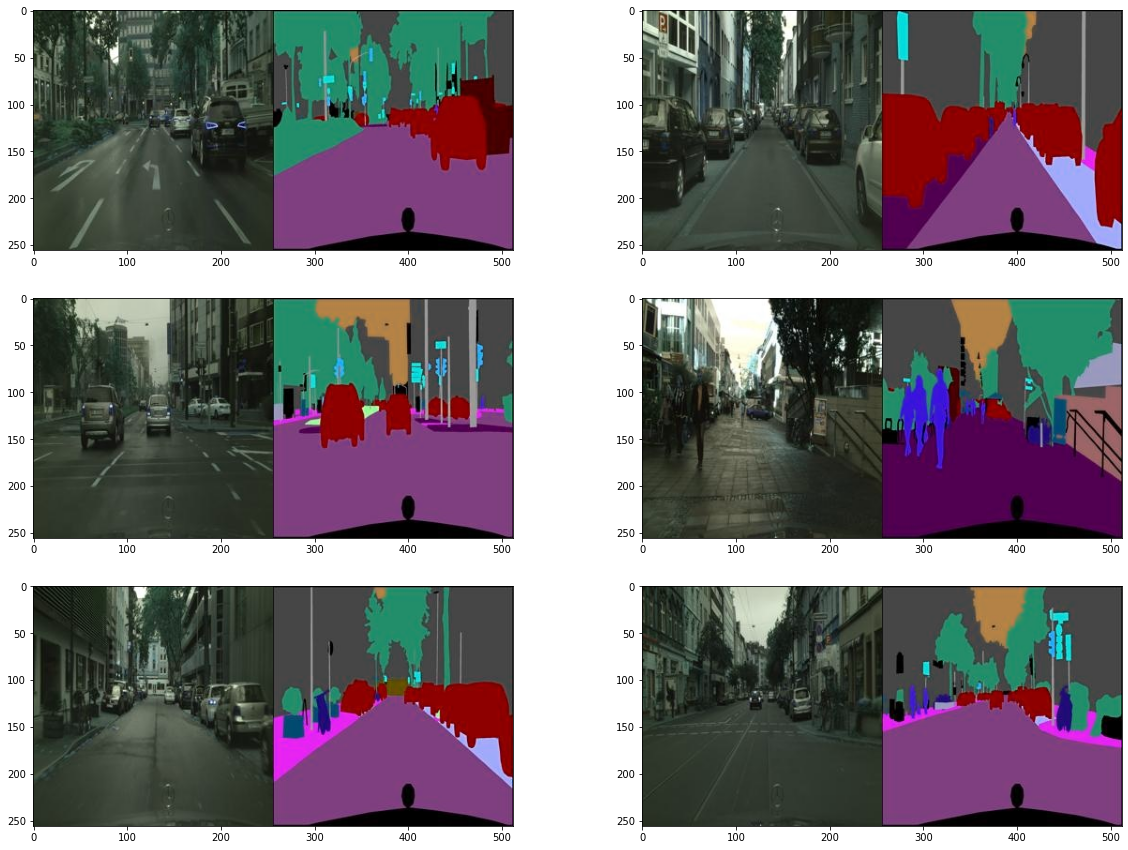

In [4]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이미지 크기 확인

In [5]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


이미지 2개로 분할하여 사용

In [6]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

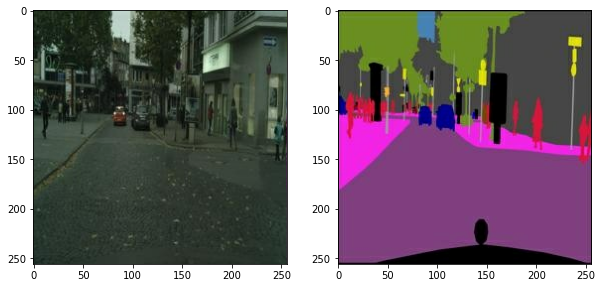

In [7]:
f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

augmentation을 이용하여 데이터셋 증가\
이미지 회전, 자르기, 뒤집기 적용

In [8]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

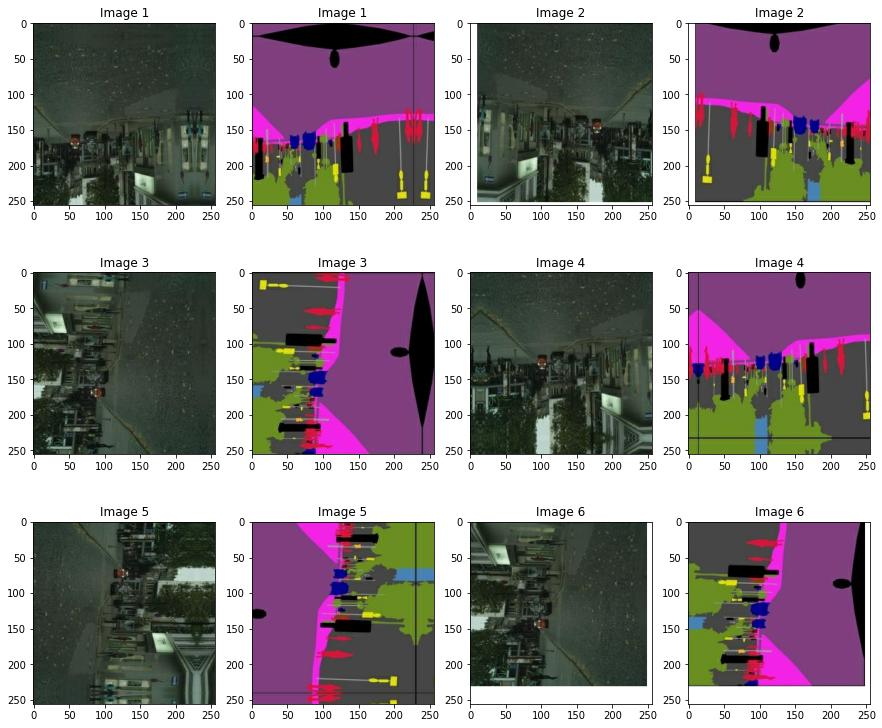

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [10]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

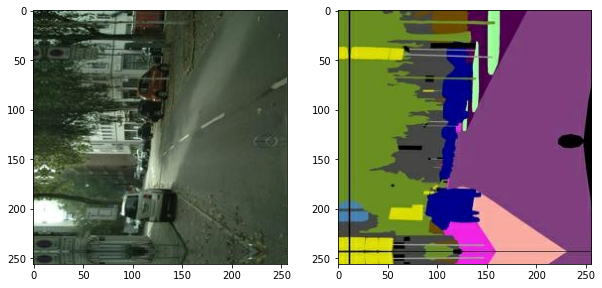

In [11]:
train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 구성
---
pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.\
U-Net generator 모델

In [12]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [14]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [15]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [16]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [17]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [18]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_8 (EncodeBlock)    (None, 128, 128, 64) 3072        input_3[0][0]                    
__________________________________________________________________________________________________
encode_block_9 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block_8[0][0]             
__________________________________________________________________________________________________
encode_block_10 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_9[0][0]             
____________________________________________________________________________________________

### Discriminator 구성
---
Discriminator 모델

In [19]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [20]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_30 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [21]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [22]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

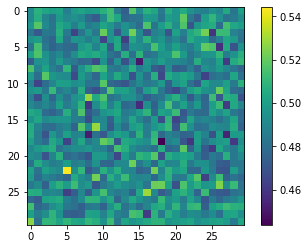

In [23]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 모델 학습
---
학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

In [24]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [25]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [26]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [27]:
EPOCHS = 300

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9210                     
L1_loss:0.3191                     
Discriminator_loss:1.1970

EPOCH[1] - STEP[20]                     
Generator_loss:1.0913                     
L1_loss:0.3276                     
Discriminator_loss:1.2471

EPOCH[1] - STEP[30]                     
Generator_loss:1.3742                     
L1_loss:0.2651                     
Discriminator_loss:0.8285

EPOCH[1] - STEP[40]                     
Generator_loss:1.5364                     
L1_loss:0.3013                     
Discriminator_loss:0.9916

EPOCH[1] - STEP[50]                     
Generator_loss:1.9983                     
L1_loss:0.2978                     
Discriminator_loss:0.4686

EPOCH[1] - STEP[60]                     
Generator_loss:1.5595                     
L1_loss:0.2711                     
Discriminator_loss:0.6103

EPOCH[1] - STEP[70]                     
Generator_loss:1.6058                     
L1_loss:0.2527                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.2554                     
L1_loss:0.2325                     
Discriminator_loss:0.6969

EPOCH[3] - STEP[80]                     
Generator_loss:1.8578                     
L1_loss:0.2186                     
Discriminator_loss:0.4250

EPOCH[3] - STEP[90]                     
Generator_loss:0.8156                     
L1_loss:0.2099                     
Discriminator_loss:0.7616

EPOCH[3] - STEP[100]                     
Generator_loss:1.8783                     
L1_loss:0.2218                     
Discriminator_loss:0.6921

EPOCH[3] - STEP[110]                     
Generator_loss:1.8764                     
L1_loss:0.2129                     
Discriminator_loss:0.8533

EPOCH[3] - STEP[120]                     
Generator_loss:3.1400                     
L1_loss:0.1928                     
Discriminator_loss:0.6640

EPOCH[3] - STEP[130]                     
Generator_loss:1.2599                     
L1_loss:0.1912                

EPOCH[5] - STEP[130]                     
Generator_loss:0.9358                     
L1_loss:0.1685                     
Discriminator_loss:0.7592

EPOCH[5] - STEP[140]                     
Generator_loss:0.7890                     
L1_loss:0.1935                     
Discriminator_loss:0.8656

EPOCH[5] - STEP[150]                     
Generator_loss:1.7519                     
L1_loss:0.1917                     
Discriminator_loss:0.5710

EPOCH[5] - STEP[160]                     
Generator_loss:1.1509                     
L1_loss:0.1533                     
Discriminator_loss:2.3086

EPOCH[5] - STEP[170]                     
Generator_loss:2.9805                     
L1_loss:0.1679                     
Discriminator_loss:1.7431

EPOCH[5] - STEP[180]                     
Generator_loss:1.9932                     
L1_loss:0.2535                     
Discriminator_loss:0.3661

EPOCH[5] - STEP[190]                     
Generator_loss:1.9089                     
L1_loss:0.1659             

EPOCH[7] - STEP[190]                     
Generator_loss:0.8823                     
L1_loss:0.1872                     
Discriminator_loss:0.7870

EPOCH[7] - STEP[200]                     
Generator_loss:0.7690                     
L1_loss:0.1769                     
Discriminator_loss:1.0888

EPOCH[7] - STEP[210]                     
Generator_loss:1.4690                     
L1_loss:0.1834                     
Discriminator_loss:0.5171

EPOCH[7] - STEP[220]                     
Generator_loss:1.6136                     
L1_loss:0.2093                     
Discriminator_loss:0.3941

EPOCH[7] - STEP[230]                     
Generator_loss:2.6753                     
L1_loss:0.1825                     
Discriminator_loss:1.3322

EPOCH[7] - STEP[240]                     
Generator_loss:0.9439                     
L1_loss:0.1588                     
Discriminator_loss:0.9202

EPOCH[7] - STEP[250]                     
Generator_loss:2.7051                     
L1_loss:0.1662             

EPOCH[9] - STEP[250]                     
Generator_loss:2.1123                     
L1_loss:0.1819                     
Discriminator_loss:0.4467

EPOCH[10] - STEP[10]                     
Generator_loss:1.8670                     
L1_loss:0.2257                     
Discriminator_loss:0.5845

EPOCH[10] - STEP[20]                     
Generator_loss:1.4736                     
L1_loss:0.1575                     
Discriminator_loss:1.5559

EPOCH[10] - STEP[30]                     
Generator_loss:3.1187                     
L1_loss:0.1906                     
Discriminator_loss:0.5012

EPOCH[10] - STEP[40]                     
Generator_loss:2.6030                     
L1_loss:0.1943                     
Discriminator_loss:0.7723

EPOCH[10] - STEP[50]                     
Generator_loss:1.9629                     
L1_loss:0.1802                     
Discriminator_loss:0.3724

EPOCH[10] - STEP[60]                     
Generator_loss:2.2475                     
L1_loss:0.2244             

EPOCH[12] - STEP[60]                     
Generator_loss:1.0065                     
L1_loss:0.1548                     
Discriminator_loss:0.7132

EPOCH[12] - STEP[70]                     
Generator_loss:1.9740                     
L1_loss:0.1594                     
Discriminator_loss:0.4077

EPOCH[12] - STEP[80]                     
Generator_loss:2.4753                     
L1_loss:0.1638                     
Discriminator_loss:1.6407

EPOCH[12] - STEP[90]                     
Generator_loss:0.6846                     
L1_loss:0.1754                     
Discriminator_loss:0.9898

EPOCH[12] - STEP[100]                     
Generator_loss:2.0345                     
L1_loss:0.1726                     
Discriminator_loss:0.8057

EPOCH[12] - STEP[110]                     
Generator_loss:2.2091                     
L1_loss:0.1974                     
Discriminator_loss:0.4721

EPOCH[12] - STEP[120]                     
Generator_loss:2.8349                     
L1_loss:0.1987          

EPOCH[14] - STEP[120]                     
Generator_loss:2.1350                     
L1_loss:0.1810                     
Discriminator_loss:0.3613

EPOCH[14] - STEP[130]                     
Generator_loss:1.9571                     
L1_loss:0.1651                     
Discriminator_loss:0.3044

EPOCH[14] - STEP[140]                     
Generator_loss:2.3528                     
L1_loss:0.1529                     
Discriminator_loss:0.8054

EPOCH[14] - STEP[150]                     
Generator_loss:2.2605                     
L1_loss:0.1733                     
Discriminator_loss:0.3819

EPOCH[14] - STEP[160]                     
Generator_loss:1.2908                     
L1_loss:0.1646                     
Discriminator_loss:0.4909

EPOCH[14] - STEP[170]                     
Generator_loss:1.9616                     
L1_loss:0.1572                     
Discriminator_loss:1.0530

EPOCH[14] - STEP[180]                     
Generator_loss:0.4339                     
L1_loss:0.1956      

EPOCH[16] - STEP[180]                     
Generator_loss:1.1276                     
L1_loss:0.1452                     
Discriminator_loss:0.5692

EPOCH[16] - STEP[190]                     
Generator_loss:1.8701                     
L1_loss:0.1462                     
Discriminator_loss:0.3120

EPOCH[16] - STEP[200]                     
Generator_loss:2.8506                     
L1_loss:0.1959                     
Discriminator_loss:0.4468

EPOCH[16] - STEP[210]                     
Generator_loss:2.6539                     
L1_loss:0.1814                     
Discriminator_loss:0.6191

EPOCH[16] - STEP[220]                     
Generator_loss:3.3453                     
L1_loss:0.1278                     
Discriminator_loss:0.9202

EPOCH[16] - STEP[230]                     
Generator_loss:3.6440                     
L1_loss:0.1963                     
Discriminator_loss:0.3673

EPOCH[16] - STEP[240]                     
Generator_loss:0.5748                     
L1_loss:0.1807      

EPOCH[18] - STEP[240]                     
Generator_loss:2.6431                     
L1_loss:0.1419                     
Discriminator_loss:0.5081

EPOCH[18] - STEP[250]                     
Generator_loss:1.4523                     
L1_loss:0.1554                     
Discriminator_loss:0.4349

EPOCH[19] - STEP[10]                     
Generator_loss:1.1326                     
L1_loss:0.1707                     
Discriminator_loss:0.6660

EPOCH[19] - STEP[20]                     
Generator_loss:2.9416                     
L1_loss:0.1686                     
Discriminator_loss:0.6249

EPOCH[19] - STEP[30]                     
Generator_loss:2.3976                     
L1_loss:0.1998                     
Discriminator_loss:0.3984

EPOCH[19] - STEP[40]                     
Generator_loss:3.0246                     
L1_loss:0.1543                     
Discriminator_loss:0.6304

EPOCH[19] - STEP[50]                     
Generator_loss:2.6232                     
L1_loss:0.1856           

EPOCH[21] - STEP[50]                     
Generator_loss:2.9270                     
L1_loss:0.1400                     
Discriminator_loss:1.0586

EPOCH[21] - STEP[60]                     
Generator_loss:1.2125                     
L1_loss:0.1668                     
Discriminator_loss:0.6279

EPOCH[21] - STEP[70]                     
Generator_loss:3.0463                     
L1_loss:0.1498                     
Discriminator_loss:0.8731

EPOCH[21] - STEP[80]                     
Generator_loss:2.0405                     
L1_loss:0.1640                     
Discriminator_loss:0.4268

EPOCH[21] - STEP[90]                     
Generator_loss:1.8132                     
L1_loss:0.1249                     
Discriminator_loss:0.6453

EPOCH[21] - STEP[100]                     
Generator_loss:2.5356                     
L1_loss:0.1173                     
Discriminator_loss:1.3301

EPOCH[21] - STEP[110]                     
Generator_loss:1.2788                     
L1_loss:0.1372           

EPOCH[23] - STEP[110]                     
Generator_loss:1.8699                     
L1_loss:0.1655                     
Discriminator_loss:0.4290

EPOCH[23] - STEP[120]                     
Generator_loss:2.7100                     
L1_loss:0.1342                     
Discriminator_loss:0.5490

EPOCH[23] - STEP[130]                     
Generator_loss:2.2388                     
L1_loss:0.1542                     
Discriminator_loss:0.5205

EPOCH[23] - STEP[140]                     
Generator_loss:1.9048                     
L1_loss:0.1515                     
Discriminator_loss:0.3926

EPOCH[23] - STEP[150]                     
Generator_loss:1.4788                     
L1_loss:0.1695                     
Discriminator_loss:0.5152

EPOCH[23] - STEP[160]                     
Generator_loss:2.5979                     
L1_loss:0.1637                     
Discriminator_loss:0.5164

EPOCH[23] - STEP[170]                     
Generator_loss:1.3962                     
L1_loss:0.1621      

EPOCH[25] - STEP[170]                     
Generator_loss:1.8954                     
L1_loss:0.1475                     
Discriminator_loss:0.5595

EPOCH[25] - STEP[180]                     
Generator_loss:1.8483                     
L1_loss:0.1270                     
Discriminator_loss:0.9418

EPOCH[25] - STEP[190]                     
Generator_loss:2.6088                     
L1_loss:0.1896                     
Discriminator_loss:0.2250

EPOCH[25] - STEP[200]                     
Generator_loss:1.9936                     
L1_loss:0.1604                     
Discriminator_loss:0.3211

EPOCH[25] - STEP[210]                     
Generator_loss:3.3676                     
L1_loss:0.1419                     
Discriminator_loss:1.0601

EPOCH[25] - STEP[220]                     
Generator_loss:1.8819                     
L1_loss:0.1342                     
Discriminator_loss:0.4944

EPOCH[25] - STEP[230]                     
Generator_loss:3.2785                     
L1_loss:0.1752      

EPOCH[27] - STEP[230]                     
Generator_loss:1.7280                     
L1_loss:0.1328                     
Discriminator_loss:0.5907

EPOCH[27] - STEP[240]                     
Generator_loss:1.5108                     
L1_loss:0.1833                     
Discriminator_loss:0.5604

EPOCH[27] - STEP[250]                     
Generator_loss:2.6883                     
L1_loss:0.1275                     
Discriminator_loss:0.4755

EPOCH[28] - STEP[10]                     
Generator_loss:2.9462                     
L1_loss:0.1510                     
Discriminator_loss:0.3269

EPOCH[28] - STEP[20]                     
Generator_loss:3.3499                     
L1_loss:0.1722                     
Discriminator_loss:0.2837

EPOCH[28] - STEP[30]                     
Generator_loss:0.7427                     
L1_loss:0.1547                     
Discriminator_loss:0.9400

EPOCH[28] - STEP[40]                     
Generator_loss:1.4554                     
L1_loss:0.1717          

EPOCH[30] - STEP[40]                     
Generator_loss:4.0802                     
L1_loss:0.1732                     
Discriminator_loss:0.2834

EPOCH[30] - STEP[50]                     
Generator_loss:3.9392                     
L1_loss:0.1365                     
Discriminator_loss:1.3865

EPOCH[30] - STEP[60]                     
Generator_loss:1.0273                     
L1_loss:0.1313                     
Discriminator_loss:0.7046

EPOCH[30] - STEP[70]                     
Generator_loss:2.0593                     
L1_loss:0.1383                     
Discriminator_loss:0.6331

EPOCH[30] - STEP[80]                     
Generator_loss:1.4831                     
L1_loss:0.1282                     
Discriminator_loss:1.3478

EPOCH[30] - STEP[90]                     
Generator_loss:4.1505                     
L1_loss:0.1792                     
Discriminator_loss:1.2827

EPOCH[30] - STEP[100]                     
Generator_loss:3.5054                     
L1_loss:0.1460            

EPOCH[32] - STEP[100]                     
Generator_loss:1.4218                     
L1_loss:0.1752                     
Discriminator_loss:0.6227

EPOCH[32] - STEP[110]                     
Generator_loss:1.8083                     
L1_loss:0.1554                     
Discriminator_loss:0.6933

EPOCH[32] - STEP[120]                     
Generator_loss:2.4581                     
L1_loss:0.1283                     
Discriminator_loss:0.9416

EPOCH[32] - STEP[130]                     
Generator_loss:1.1659                     
L1_loss:0.1904                     
Discriminator_loss:0.7079

EPOCH[32] - STEP[140]                     
Generator_loss:3.5678                     
L1_loss:0.1780                     
Discriminator_loss:0.3349

EPOCH[32] - STEP[150]                     
Generator_loss:3.5223                     
L1_loss:0.1346                     
Discriminator_loss:0.8944

EPOCH[32] - STEP[160]                     
Generator_loss:2.2183                     
L1_loss:0.1646      

EPOCH[34] - STEP[160]                     
Generator_loss:2.3469                     
L1_loss:0.1415                     
Discriminator_loss:0.4156

EPOCH[34] - STEP[170]                     
Generator_loss:2.1651                     
L1_loss:0.1229                     
Discriminator_loss:0.9034

EPOCH[34] - STEP[180]                     
Generator_loss:3.9531                     
L1_loss:0.1867                     
Discriminator_loss:0.1948

EPOCH[34] - STEP[190]                     
Generator_loss:4.0842                     
L1_loss:0.1326                     
Discriminator_loss:0.6391

EPOCH[34] - STEP[200]                     
Generator_loss:3.6409                     
L1_loss:0.1461                     
Discriminator_loss:0.4477

EPOCH[34] - STEP[210]                     
Generator_loss:0.5866                     
L1_loss:0.1555                     
Discriminator_loss:1.0757

EPOCH[34] - STEP[220]                     
Generator_loss:1.6045                     
L1_loss:0.1762      

EPOCH[36] - STEP[220]                     
Generator_loss:1.9721                     
L1_loss:0.1521                     
Discriminator_loss:0.3910

EPOCH[36] - STEP[230]                     
Generator_loss:1.1582                     
L1_loss:0.1368                     
Discriminator_loss:0.8420

EPOCH[36] - STEP[240]                     
Generator_loss:1.6683                     
L1_loss:0.1215                     
Discriminator_loss:0.9344

EPOCH[36] - STEP[250]                     
Generator_loss:2.9440                     
L1_loss:0.1620                     
Discriminator_loss:0.1853

EPOCH[37] - STEP[10]                     
Generator_loss:0.9087                     
L1_loss:0.1138                     
Discriminator_loss:1.4707

EPOCH[37] - STEP[20]                     
Generator_loss:1.7453                     
L1_loss:0.1327                     
Discriminator_loss:0.3683

EPOCH[37] - STEP[30]                     
Generator_loss:1.8783                     
L1_loss:0.1403         

EPOCH[39] - STEP[30]                     
Generator_loss:2.4542                     
L1_loss:0.1721                     
Discriminator_loss:0.2646

EPOCH[39] - STEP[40]                     
Generator_loss:1.5117                     
L1_loss:0.2063                     
Discriminator_loss:0.3525

EPOCH[39] - STEP[50]                     
Generator_loss:3.4047                     
L1_loss:0.1653                     
Discriminator_loss:0.8613

EPOCH[39] - STEP[60]                     
Generator_loss:1.9982                     
L1_loss:0.1732                     
Discriminator_loss:0.2216

EPOCH[39] - STEP[70]                     
Generator_loss:2.1908                     
L1_loss:0.1597                     
Discriminator_loss:0.2813

EPOCH[39] - STEP[80]                     
Generator_loss:0.7767                     
L1_loss:0.1228                     
Discriminator_loss:1.1210

EPOCH[39] - STEP[90]                     
Generator_loss:1.8760                     
L1_loss:0.1412             

EPOCH[41] - STEP[90]                     
Generator_loss:0.9106                     
L1_loss:0.1332                     
Discriminator_loss:2.3489

EPOCH[41] - STEP[100]                     
Generator_loss:2.5621                     
L1_loss:0.1524                     
Discriminator_loss:0.3097

EPOCH[41] - STEP[110]                     
Generator_loss:1.9182                     
L1_loss:0.1607                     
Discriminator_loss:0.5228

EPOCH[41] - STEP[120]                     
Generator_loss:3.6516                     
L1_loss:0.1331                     
Discriminator_loss:0.8714

EPOCH[41] - STEP[130]                     
Generator_loss:2.5256                     
L1_loss:0.1429                     
Discriminator_loss:0.5535

EPOCH[41] - STEP[140]                     
Generator_loss:1.6017                     
L1_loss:0.1315                     
Discriminator_loss:0.4172

EPOCH[41] - STEP[150]                     
Generator_loss:2.0404                     
L1_loss:0.1446       

EPOCH[43] - STEP[150]                     
Generator_loss:4.2767                     
L1_loss:0.1256                     
Discriminator_loss:0.5019

EPOCH[43] - STEP[160]                     
Generator_loss:3.2801                     
L1_loss:0.1478                     
Discriminator_loss:0.4594

EPOCH[43] - STEP[170]                     
Generator_loss:2.9142                     
L1_loss:0.1630                     
Discriminator_loss:0.1693

EPOCH[43] - STEP[180]                     
Generator_loss:2.8193                     
L1_loss:0.1300                     
Discriminator_loss:0.2146

EPOCH[43] - STEP[190]                     
Generator_loss:1.7728                     
L1_loss:0.1625                     
Discriminator_loss:0.5363

EPOCH[43] - STEP[200]                     
Generator_loss:3.1675                     
L1_loss:0.1175                     
Discriminator_loss:0.1675

EPOCH[43] - STEP[210]                     
Generator_loss:3.0135                     
L1_loss:0.1335      

EPOCH[45] - STEP[210]                     
Generator_loss:1.5231                     
L1_loss:0.1698                     
Discriminator_loss:0.3434

EPOCH[45] - STEP[220]                     
Generator_loss:1.7088                     
L1_loss:0.1365                     
Discriminator_loss:0.3669

EPOCH[45] - STEP[230]                     
Generator_loss:2.9533                     
L1_loss:0.1693                     
Discriminator_loss:0.3078

EPOCH[45] - STEP[240]                     
Generator_loss:1.0485                     
L1_loss:0.1385                     
Discriminator_loss:1.0409

EPOCH[45] - STEP[250]                     
Generator_loss:2.0598                     
L1_loss:0.1615                     
Discriminator_loss:0.2957

EPOCH[46] - STEP[10]                     
Generator_loss:1.5886                     
L1_loss:0.2073                     
Discriminator_loss:0.4730

EPOCH[46] - STEP[20]                     
Generator_loss:1.0687                     
L1_loss:0.1354        

EPOCH[48] - STEP[20]                     
Generator_loss:3.7010                     
L1_loss:0.1542                     
Discriminator_loss:0.9857

EPOCH[48] - STEP[30]                     
Generator_loss:3.2365                     
L1_loss:0.1430                     
Discriminator_loss:0.5173

EPOCH[48] - STEP[40]                     
Generator_loss:3.2628                     
L1_loss:0.1544                     
Discriminator_loss:0.2425

EPOCH[48] - STEP[50]                     
Generator_loss:4.3690                     
L1_loss:0.1443                     
Discriminator_loss:0.6770

EPOCH[48] - STEP[60]                     
Generator_loss:1.0866                     
L1_loss:0.1460                     
Discriminator_loss:0.7044

EPOCH[48] - STEP[70]                     
Generator_loss:0.9398                     
L1_loss:0.1829                     
Discriminator_loss:0.8719

EPOCH[48] - STEP[80]                     
Generator_loss:2.6169                     
L1_loss:0.1297             

EPOCH[50] - STEP[80]                     
Generator_loss:2.2552                     
L1_loss:0.1659                     
Discriminator_loss:0.3239

EPOCH[50] - STEP[90]                     
Generator_loss:3.9685                     
L1_loss:0.1760                     
Discriminator_loss:0.0911

EPOCH[50] - STEP[100]                     
Generator_loss:1.8001                     
L1_loss:0.1439                     
Discriminator_loss:0.3743

EPOCH[50] - STEP[110]                     
Generator_loss:3.8118                     
L1_loss:0.1834                     
Discriminator_loss:0.0995

EPOCH[50] - STEP[120]                     
Generator_loss:1.8643                     
L1_loss:0.1303                     
Discriminator_loss:0.3362

EPOCH[50] - STEP[130]                     
Generator_loss:2.2453                     
L1_loss:0.1326                     
Discriminator_loss:0.2514

EPOCH[50] - STEP[140]                     
Generator_loss:3.1522                     
L1_loss:0.1378        

EPOCH[52] - STEP[140]                     
Generator_loss:1.9243                     
L1_loss:0.1513                     
Discriminator_loss:0.4112

EPOCH[52] - STEP[150]                     
Generator_loss:1.0077                     
L1_loss:0.1442                     
Discriminator_loss:0.6638

EPOCH[52] - STEP[160]                     
Generator_loss:2.3594                     
L1_loss:0.1400                     
Discriminator_loss:0.2764

EPOCH[52] - STEP[170]                     
Generator_loss:1.7033                     
L1_loss:0.1396                     
Discriminator_loss:0.4080

EPOCH[52] - STEP[180]                     
Generator_loss:4.9532                     
L1_loss:0.1571                     
Discriminator_loss:0.4121

EPOCH[52] - STEP[190]                     
Generator_loss:3.2507                     
L1_loss:0.1909                     
Discriminator_loss:0.1307

EPOCH[52] - STEP[200]                     
Generator_loss:2.1468                     
L1_loss:0.1486      

EPOCH[54] - STEP[200]                     
Generator_loss:1.4911                     
L1_loss:0.1834                     
Discriminator_loss:0.4758

EPOCH[54] - STEP[210]                     
Generator_loss:5.7750                     
L1_loss:0.1616                     
Discriminator_loss:0.0901

EPOCH[54] - STEP[220]                     
Generator_loss:2.1248                     
L1_loss:0.1448                     
Discriminator_loss:0.7562

EPOCH[54] - STEP[230]                     
Generator_loss:6.8773                     
L1_loss:0.1366                     
Discriminator_loss:2.7831

EPOCH[54] - STEP[240]                     
Generator_loss:4.8534                     
L1_loss:0.1529                     
Discriminator_loss:0.3123

EPOCH[54] - STEP[250]                     
Generator_loss:2.7743                     
L1_loss:0.1218                     
Discriminator_loss:0.1879

EPOCH[55] - STEP[10]                     
Generator_loss:1.3172                     
L1_loss:0.1298       

EPOCH[57] - STEP[10]                     
Generator_loss:3.7492                     
L1_loss:0.1504                     
Discriminator_loss:0.1559

EPOCH[57] - STEP[20]                     
Generator_loss:1.5068                     
L1_loss:0.1253                     
Discriminator_loss:0.4820

EPOCH[57] - STEP[30]                     
Generator_loss:3.3282                     
L1_loss:0.1520                     
Discriminator_loss:0.1717

EPOCH[57] - STEP[40]                     
Generator_loss:2.2079                     
L1_loss:0.1311                     
Discriminator_loss:0.2280

EPOCH[57] - STEP[50]                     
Generator_loss:3.6728                     
L1_loss:0.1520                     
Discriminator_loss:0.3432

EPOCH[57] - STEP[60]                     
Generator_loss:4.3045                     
L1_loss:0.1301                     
Discriminator_loss:0.1993

EPOCH[57] - STEP[70]                     
Generator_loss:1.4819                     
L1_loss:0.1424             

EPOCH[59] - STEP[70]                     
Generator_loss:2.1796                     
L1_loss:0.1137                     
Discriminator_loss:0.3005

EPOCH[59] - STEP[80]                     
Generator_loss:1.8643                     
L1_loss:0.1032                     
Discriminator_loss:0.8371

EPOCH[59] - STEP[90]                     
Generator_loss:1.9354                     
L1_loss:0.1570                     
Discriminator_loss:0.3850

EPOCH[59] - STEP[100]                     
Generator_loss:5.0391                     
L1_loss:0.1383                     
Discriminator_loss:0.9905

EPOCH[59] - STEP[110]                     
Generator_loss:2.6071                     
L1_loss:0.1372                     
Discriminator_loss:0.2462

EPOCH[59] - STEP[120]                     
Generator_loss:5.3119                     
L1_loss:0.1493                     
Discriminator_loss:0.2612

EPOCH[59] - STEP[130]                     
Generator_loss:2.8518                     
L1_loss:0.1246         

EPOCH[61] - STEP[130]                     
Generator_loss:3.2120                     
L1_loss:0.1231                     
Discriminator_loss:0.7746

EPOCH[61] - STEP[140]                     
Generator_loss:1.1194                     
L1_loss:0.1393                     
Discriminator_loss:0.6353

EPOCH[61] - STEP[150]                     
Generator_loss:2.7586                     
L1_loss:0.1441                     
Discriminator_loss:0.3112

EPOCH[61] - STEP[160]                     
Generator_loss:2.2643                     
L1_loss:0.1383                     
Discriminator_loss:0.4464

EPOCH[61] - STEP[170]                     
Generator_loss:2.2535                     
L1_loss:0.1244                     
Discriminator_loss:0.5983

EPOCH[61] - STEP[180]                     
Generator_loss:2.5496                     
L1_loss:0.1355                     
Discriminator_loss:0.2034

EPOCH[61] - STEP[190]                     
Generator_loss:1.9579                     
L1_loss:0.1629      

EPOCH[63] - STEP[190]                     
Generator_loss:0.8277                     
L1_loss:0.1174                     
Discriminator_loss:1.4208

EPOCH[63] - STEP[200]                     
Generator_loss:1.4687                     
L1_loss:0.1193                     
Discriminator_loss:0.8372

EPOCH[63] - STEP[210]                     
Generator_loss:4.0140                     
L1_loss:0.1230                     
Discriminator_loss:0.1918

EPOCH[63] - STEP[220]                     
Generator_loss:2.4460                     
L1_loss:0.1628                     
Discriminator_loss:0.1832

EPOCH[63] - STEP[230]                     
Generator_loss:5.9881                     
L1_loss:0.1242                     
Discriminator_loss:1.1532

EPOCH[63] - STEP[240]                     
Generator_loss:4.7074                     
L1_loss:0.1747                     
Discriminator_loss:0.2129

EPOCH[63] - STEP[250]                     
Generator_loss:4.2493                     
L1_loss:0.1550      

EPOCH[65] - STEP[250]                     
Generator_loss:4.1830                     
L1_loss:0.1199                     
Discriminator_loss:0.2145

EPOCH[66] - STEP[10]                     
Generator_loss:2.5973                     
L1_loss:0.1436                     
Discriminator_loss:0.1512

EPOCH[66] - STEP[20]                     
Generator_loss:2.2202                     
L1_loss:0.1211                     
Discriminator_loss:0.2503

EPOCH[66] - STEP[30]                     
Generator_loss:1.8155                     
L1_loss:0.1431                     
Discriminator_loss:0.3177

EPOCH[66] - STEP[40]                     
Generator_loss:3.5710                     
L1_loss:0.1064                     
Discriminator_loss:0.6558

EPOCH[66] - STEP[50]                     
Generator_loss:2.5804                     
L1_loss:0.1240                     
Discriminator_loss:0.1721

EPOCH[66] - STEP[60]                     
Generator_loss:3.4602                     
L1_loss:0.1207            

EPOCH[68] - STEP[60]                     
Generator_loss:3.8310                     
L1_loss:0.1358                     
Discriminator_loss:0.2545

EPOCH[68] - STEP[70]                     
Generator_loss:3.6238                     
L1_loss:0.1211                     
Discriminator_loss:0.0795

EPOCH[68] - STEP[80]                     
Generator_loss:4.5593                     
L1_loss:0.1406                     
Discriminator_loss:0.6888

EPOCH[68] - STEP[90]                     
Generator_loss:3.9361                     
L1_loss:0.1393                     
Discriminator_loss:0.1008

EPOCH[68] - STEP[100]                     
Generator_loss:2.1295                     
L1_loss:0.1519                     
Discriminator_loss:0.2007

EPOCH[68] - STEP[110]                     
Generator_loss:3.9623                     
L1_loss:0.1402                     
Discriminator_loss:0.1337

EPOCH[68] - STEP[120]                     
Generator_loss:2.3323                     
L1_loss:0.1390          

EPOCH[70] - STEP[120]                     
Generator_loss:2.4561                     
L1_loss:0.1684                     
Discriminator_loss:0.2818

EPOCH[70] - STEP[130]                     
Generator_loss:2.8545                     
L1_loss:0.1226                     
Discriminator_loss:0.4752

EPOCH[70] - STEP[140]                     
Generator_loss:2.3080                     
L1_loss:0.1390                     
Discriminator_loss:0.2543

EPOCH[70] - STEP[150]                     
Generator_loss:4.8929                     
L1_loss:0.1215                     
Discriminator_loss:0.3407

EPOCH[70] - STEP[160]                     
Generator_loss:4.1375                     
L1_loss:0.1800                     
Discriminator_loss:0.1798

EPOCH[70] - STEP[170]                     
Generator_loss:2.3447                     
L1_loss:0.1578                     
Discriminator_loss:0.3113

EPOCH[70] - STEP[180]                     
Generator_loss:4.8817                     
L1_loss:0.1637      

EPOCH[72] - STEP[180]                     
Generator_loss:4.4593                     
L1_loss:0.1136                     
Discriminator_loss:0.1324

EPOCH[72] - STEP[190]                     
Generator_loss:2.9890                     
L1_loss:0.1378                     
Discriminator_loss:0.1729

EPOCH[72] - STEP[200]                     
Generator_loss:5.9500                     
L1_loss:0.1304                     
Discriminator_loss:0.2701

EPOCH[72] - STEP[210]                     
Generator_loss:3.4723                     
L1_loss:0.1568                     
Discriminator_loss:0.0861

EPOCH[72] - STEP[220]                     
Generator_loss:2.8618                     
L1_loss:0.1297                     
Discriminator_loss:0.2757

EPOCH[72] - STEP[230]                     
Generator_loss:3.9161                     
L1_loss:0.1291                     
Discriminator_loss:0.2456

EPOCH[72] - STEP[240]                     
Generator_loss:4.0542                     
L1_loss:0.1571      

EPOCH[74] - STEP[240]                     
Generator_loss:2.7666                     
L1_loss:0.1525                     
Discriminator_loss:0.2082

EPOCH[74] - STEP[250]                     
Generator_loss:2.5665                     
L1_loss:0.1614                     
Discriminator_loss:0.1732

EPOCH[75] - STEP[10]                     
Generator_loss:3.9905                     
L1_loss:0.1234                     
Discriminator_loss:0.7723

EPOCH[75] - STEP[20]                     
Generator_loss:5.8890                     
L1_loss:0.1743                     
Discriminator_loss:0.1213

EPOCH[75] - STEP[30]                     
Generator_loss:4.9912                     
L1_loss:0.1296                     
Discriminator_loss:0.6921

EPOCH[75] - STEP[40]                     
Generator_loss:1.1023                     
L1_loss:0.1272                     
Discriminator_loss:0.8249

EPOCH[75] - STEP[50]                     
Generator_loss:3.2802                     
L1_loss:0.1403           

EPOCH[77] - STEP[50]                     
Generator_loss:4.6081                     
L1_loss:0.1473                     
Discriminator_loss:0.3454

EPOCH[77] - STEP[60]                     
Generator_loss:1.8565                     
L1_loss:0.1658                     
Discriminator_loss:0.3606

EPOCH[77] - STEP[70]                     
Generator_loss:4.9107                     
L1_loss:0.1612                     
Discriminator_loss:0.1488

EPOCH[77] - STEP[80]                     
Generator_loss:2.6640                     
L1_loss:0.1359                     
Discriminator_loss:0.1956

EPOCH[77] - STEP[90]                     
Generator_loss:2.7943                     
L1_loss:0.1704                     
Discriminator_loss:0.3210

EPOCH[77] - STEP[100]                     
Generator_loss:2.5482                     
L1_loss:0.1183                     
Discriminator_loss:0.6404

EPOCH[77] - STEP[110]                     
Generator_loss:3.3081                     
L1_loss:0.1304           

EPOCH[79] - STEP[110]                     
Generator_loss:3.2221                     
L1_loss:0.1209                     
Discriminator_loss:0.2463

EPOCH[79] - STEP[120]                     
Generator_loss:2.6280                     
L1_loss:0.1663                     
Discriminator_loss:0.1806

EPOCH[79] - STEP[130]                     
Generator_loss:4.7818                     
L1_loss:0.1270                     
Discriminator_loss:1.3786

EPOCH[79] - STEP[140]                     
Generator_loss:2.5521                     
L1_loss:0.1413                     
Discriminator_loss:0.2175

EPOCH[79] - STEP[150]                     
Generator_loss:2.4097                     
L1_loss:0.1447                     
Discriminator_loss:0.2325

EPOCH[79] - STEP[160]                     
Generator_loss:3.9967                     
L1_loss:0.1289                     
Discriminator_loss:0.1944

EPOCH[79] - STEP[170]                     
Generator_loss:4.8929                     
L1_loss:0.1705      

EPOCH[81] - STEP[170]                     
Generator_loss:1.3155                     
L1_loss:0.1375                     
Discriminator_loss:0.6216

EPOCH[81] - STEP[180]                     
Generator_loss:2.0602                     
L1_loss:0.0993                     
Discriminator_loss:0.3130

EPOCH[81] - STEP[190]                     
Generator_loss:3.9295                     
L1_loss:0.1797                     
Discriminator_loss:0.0443

EPOCH[81] - STEP[200]                     
Generator_loss:3.8871                     
L1_loss:0.1659                     
Discriminator_loss:0.0479

EPOCH[81] - STEP[210]                     
Generator_loss:2.9448                     
L1_loss:0.1721                     
Discriminator_loss:0.1575

EPOCH[81] - STEP[220]                     
Generator_loss:5.1568                     
L1_loss:0.1456                     
Discriminator_loss:0.4232

EPOCH[81] - STEP[230]                     
Generator_loss:4.5969                     
L1_loss:0.1406      

EPOCH[83] - STEP[230]                     
Generator_loss:3.9453                     
L1_loss:0.2143                     
Discriminator_loss:0.0485

EPOCH[83] - STEP[240]                     
Generator_loss:3.4009                     
L1_loss:0.1498                     
Discriminator_loss:0.0850

EPOCH[83] - STEP[250]                     
Generator_loss:4.2719                     
L1_loss:0.1445                     
Discriminator_loss:0.2128

EPOCH[84] - STEP[10]                     
Generator_loss:3.4748                     
L1_loss:0.1365                     
Discriminator_loss:0.3558

EPOCH[84] - STEP[20]                     
Generator_loss:3.2810                     
L1_loss:0.1327                     
Discriminator_loss:0.1922

EPOCH[84] - STEP[30]                     
Generator_loss:1.7166                     
L1_loss:0.1594                     
Discriminator_loss:0.3991

EPOCH[84] - STEP[40]                     
Generator_loss:5.6313                     
L1_loss:0.1463          

EPOCH[86] - STEP[40]                     
Generator_loss:4.9229                     
L1_loss:0.1553                     
Discriminator_loss:0.6738

EPOCH[86] - STEP[50]                     
Generator_loss:1.7605                     
L1_loss:0.1145                     
Discriminator_loss:0.4080

EPOCH[86] - STEP[60]                     
Generator_loss:2.7376                     
L1_loss:0.1062                     
Discriminator_loss:0.3124

EPOCH[86] - STEP[70]                     
Generator_loss:1.6307                     
L1_loss:0.1287                     
Discriminator_loss:0.7824

EPOCH[86] - STEP[80]                     
Generator_loss:5.0768                     
L1_loss:0.1378                     
Discriminator_loss:0.0166

EPOCH[86] - STEP[90]                     
Generator_loss:3.3126                     
L1_loss:0.1155                     
Discriminator_loss:0.6822

EPOCH[86] - STEP[100]                     
Generator_loss:3.2345                     
L1_loss:0.1245            

EPOCH[88] - STEP[100]                     
Generator_loss:5.2571                     
L1_loss:0.1067                     
Discriminator_loss:0.5985

EPOCH[88] - STEP[110]                     
Generator_loss:0.6391                     
L1_loss:0.1148                     
Discriminator_loss:1.1648

EPOCH[88] - STEP[120]                     
Generator_loss:4.3071                     
L1_loss:0.1461                     
Discriminator_loss:0.1096

EPOCH[88] - STEP[130]                     
Generator_loss:4.8779                     
L1_loss:0.1818                     
Discriminator_loss:0.0245

EPOCH[88] - STEP[140]                     
Generator_loss:4.9068                     
L1_loss:0.1481                     
Discriminator_loss:0.0545

EPOCH[88] - STEP[150]                     
Generator_loss:5.2336                     
L1_loss:0.1614                     
Discriminator_loss:0.2021

EPOCH[88] - STEP[160]                     
Generator_loss:2.3820                     
L1_loss:0.1093      

EPOCH[90] - STEP[160]                     
Generator_loss:5.9743                     
L1_loss:0.1516                     
Discriminator_loss:0.0577

EPOCH[90] - STEP[170]                     
Generator_loss:6.0605                     
L1_loss:0.1308                     
Discriminator_loss:0.0938

EPOCH[90] - STEP[180]                     
Generator_loss:1.6765                     
L1_loss:0.1164                     
Discriminator_loss:0.4665

EPOCH[90] - STEP[190]                     
Generator_loss:3.3289                     
L1_loss:0.1293                     
Discriminator_loss:0.0801

EPOCH[90] - STEP[200]                     
Generator_loss:3.7374                     
L1_loss:0.1353                     
Discriminator_loss:0.0885

EPOCH[90] - STEP[210]                     
Generator_loss:5.0805                     
L1_loss:0.1467                     
Discriminator_loss:0.0579

EPOCH[90] - STEP[220]                     
Generator_loss:6.3144                     
L1_loss:0.1571      

EPOCH[92] - STEP[220]                     
Generator_loss:3.8556                     
L1_loss:0.1321                     
Discriminator_loss:0.2385

EPOCH[92] - STEP[230]                     
Generator_loss:2.9829                     
L1_loss:0.1679                     
Discriminator_loss:0.1174

EPOCH[92] - STEP[240]                     
Generator_loss:3.1491                     
L1_loss:0.1544                     
Discriminator_loss:0.1140

EPOCH[92] - STEP[250]                     
Generator_loss:2.2041                     
L1_loss:0.1669                     
Discriminator_loss:0.1892

EPOCH[93] - STEP[10]                     
Generator_loss:2.4719                     
L1_loss:0.0961                     
Discriminator_loss:0.7858

EPOCH[93] - STEP[20]                     
Generator_loss:1.2640                     
L1_loss:0.1233                     
Discriminator_loss:0.6271

EPOCH[93] - STEP[30]                     
Generator_loss:5.2592                     
L1_loss:0.1399         

EPOCH[95] - STEP[30]                     
Generator_loss:3.1828                     
L1_loss:0.1218                     
Discriminator_loss:0.0965

EPOCH[95] - STEP[40]                     
Generator_loss:3.7044                     
L1_loss:0.1296                     
Discriminator_loss:0.1104

EPOCH[95] - STEP[50]                     
Generator_loss:3.7610                     
L1_loss:0.1244                     
Discriminator_loss:0.1201

EPOCH[95] - STEP[60]                     
Generator_loss:6.3925                     
L1_loss:0.1059                     
Discriminator_loss:0.2364

EPOCH[95] - STEP[70]                     
Generator_loss:4.0348                     
L1_loss:0.1413                     
Discriminator_loss:0.3742

EPOCH[95] - STEP[80]                     
Generator_loss:3.4670                     
L1_loss:0.1300                     
Discriminator_loss:0.2209

EPOCH[95] - STEP[90]                     
Generator_loss:3.3788                     
L1_loss:0.1359             

EPOCH[97] - STEP[90]                     
Generator_loss:1.3779                     
L1_loss:0.1299                     
Discriminator_loss:0.5716

EPOCH[97] - STEP[100]                     
Generator_loss:3.3758                     
L1_loss:0.1109                     
Discriminator_loss:0.2612

EPOCH[97] - STEP[110]                     
Generator_loss:6.4002                     
L1_loss:0.1364                     
Discriminator_loss:0.5449

EPOCH[97] - STEP[120]                     
Generator_loss:5.3867                     
L1_loss:0.1328                     
Discriminator_loss:0.0403

EPOCH[97] - STEP[130]                     
Generator_loss:1.4456                     
L1_loss:0.1186                     
Discriminator_loss:0.5746

EPOCH[97] - STEP[140]                     
Generator_loss:6.1765                     
L1_loss:0.1166                     
Discriminator_loss:1.6587

EPOCH[97] - STEP[150]                     
Generator_loss:3.1083                     
L1_loss:0.1126       

EPOCH[99] - STEP[150]                     
Generator_loss:1.2843                     
L1_loss:0.1310                     
Discriminator_loss:0.7647

EPOCH[99] - STEP[160]                     
Generator_loss:4.5156                     
L1_loss:0.1252                     
Discriminator_loss:0.1869

EPOCH[99] - STEP[170]                     
Generator_loss:4.0380                     
L1_loss:0.1441                     
Discriminator_loss:0.0873

EPOCH[99] - STEP[180]                     
Generator_loss:3.6188                     
L1_loss:0.1503                     
Discriminator_loss:0.1230

EPOCH[99] - STEP[190]                     
Generator_loss:3.6429                     
L1_loss:0.1134                     
Discriminator_loss:0.1914

EPOCH[99] - STEP[200]                     
Generator_loss:4.5002                     
L1_loss:0.1645                     
Discriminator_loss:0.0224

EPOCH[99] - STEP[210]                     
Generator_loss:3.0724                     
L1_loss:0.1369      

EPOCH[101] - STEP[200]                     
Generator_loss:5.0054                     
L1_loss:0.1521                     
Discriminator_loss:0.1359

EPOCH[101] - STEP[210]                     
Generator_loss:4.4060                     
L1_loss:0.1339                     
Discriminator_loss:0.1570

EPOCH[101] - STEP[220]                     
Generator_loss:4.3560                     
L1_loss:0.1408                     
Discriminator_loss:0.0436

EPOCH[101] - STEP[230]                     
Generator_loss:3.8344                     
L1_loss:0.1166                     
Discriminator_loss:0.1243

EPOCH[101] - STEP[240]                     
Generator_loss:4.0782                     
L1_loss:0.1064                     
Discriminator_loss:0.7148

EPOCH[101] - STEP[250]                     
Generator_loss:2.8703                     
L1_loss:0.1218                     
Discriminator_loss:0.1309

EPOCH[102] - STEP[10]                     
Generator_loss:2.5348                     
L1_loss:0.1334

EPOCH[103] - STEP[250]                     
Generator_loss:2.9346                     
L1_loss:0.1222                     
Discriminator_loss:0.1248

EPOCH[104] - STEP[10]                     
Generator_loss:2.4032                     
L1_loss:0.1494                     
Discriminator_loss:0.3218

EPOCH[104] - STEP[20]                     
Generator_loss:5.4253                     
L1_loss:0.1582                     
Discriminator_loss:0.0441

EPOCH[104] - STEP[30]                     
Generator_loss:2.8182                     
L1_loss:0.1388                     
Discriminator_loss:0.4434

EPOCH[104] - STEP[40]                     
Generator_loss:4.0227                     
L1_loss:0.1045                     
Discriminator_loss:1.0098

EPOCH[104] - STEP[50]                     
Generator_loss:3.4950                     
L1_loss:0.1187                     
Discriminator_loss:0.3740

EPOCH[104] - STEP[60]                     
Generator_loss:2.7835                     
L1_loss:0.1525     

EPOCH[106] - STEP[50]                     
Generator_loss:5.2240                     
L1_loss:0.1534                     
Discriminator_loss:0.0486

EPOCH[106] - STEP[60]                     
Generator_loss:4.8577                     
L1_loss:0.1250                     
Discriminator_loss:0.3894

EPOCH[106] - STEP[70]                     
Generator_loss:5.3362                     
L1_loss:0.1382                     
Discriminator_loss:0.0229

EPOCH[106] - STEP[80]                     
Generator_loss:5.2810                     
L1_loss:0.1177                     
Discriminator_loss:0.2415

EPOCH[106] - STEP[90]                     
Generator_loss:1.5293                     
L1_loss:0.0895                     
Discriminator_loss:0.7011

EPOCH[106] - STEP[100]                     
Generator_loss:4.9653                     
L1_loss:0.1301                     
Discriminator_loss:0.1571

EPOCH[106] - STEP[110]                     
Generator_loss:7.0404                     
L1_loss:0.1058    

EPOCH[108] - STEP[100]                     
Generator_loss:2.0893                     
L1_loss:0.1764                     
Discriminator_loss:0.3313

EPOCH[108] - STEP[110]                     
Generator_loss:1.7827                     
L1_loss:0.1355                     
Discriminator_loss:0.3400

EPOCH[108] - STEP[120]                     
Generator_loss:4.9440                     
L1_loss:0.1217                     
Discriminator_loss:0.0704

EPOCH[108] - STEP[130]                     
Generator_loss:2.9926                     
L1_loss:0.1389                     
Discriminator_loss:0.2653

EPOCH[108] - STEP[140]                     
Generator_loss:8.9140                     
L1_loss:0.1362                     
Discriminator_loss:0.4421

EPOCH[108] - STEP[150]                     
Generator_loss:5.1243                     
L1_loss:0.1182                     
Discriminator_loss:0.0255

EPOCH[108] - STEP[160]                     
Generator_loss:4.5262                     
L1_loss:0.135

EPOCH[110] - STEP[150]                     
Generator_loss:3.1966                     
L1_loss:0.0949                     
Discriminator_loss:0.2676

EPOCH[110] - STEP[160]                     
Generator_loss:5.2635                     
L1_loss:0.1309                     
Discriminator_loss:0.1048

EPOCH[110] - STEP[170]                     
Generator_loss:2.8472                     
L1_loss:0.1095                     
Discriminator_loss:0.2037

EPOCH[110] - STEP[180]                     
Generator_loss:3.9019                     
L1_loss:0.1981                     
Discriminator_loss:0.1016

EPOCH[110] - STEP[190]                     
Generator_loss:4.3898                     
L1_loss:0.1155                     
Discriminator_loss:0.3757

EPOCH[110] - STEP[200]                     
Generator_loss:6.3197                     
L1_loss:0.1364                     
Discriminator_loss:0.0565

EPOCH[110] - STEP[210]                     
Generator_loss:4.9979                     
L1_loss:0.161

EPOCH[112] - STEP[200]                     
Generator_loss:2.2535                     
L1_loss:0.1748                     
Discriminator_loss:0.2756

EPOCH[112] - STEP[210]                     
Generator_loss:4.2942                     
L1_loss:0.1378                     
Discriminator_loss:0.1207

EPOCH[112] - STEP[220]                     
Generator_loss:2.1642                     
L1_loss:0.1065                     
Discriminator_loss:0.3788

EPOCH[112] - STEP[230]                     
Generator_loss:5.2598                     
L1_loss:0.1343                     
Discriminator_loss:0.0448

EPOCH[112] - STEP[240]                     
Generator_loss:5.6321                     
L1_loss:0.1261                     
Discriminator_loss:0.0339

EPOCH[112] - STEP[250]                     
Generator_loss:4.5824                     
L1_loss:0.1488                     
Discriminator_loss:0.0605

EPOCH[113] - STEP[10]                     
Generator_loss:6.8936                     
L1_loss:0.1329

EPOCH[114] - STEP[250]                     
Generator_loss:6.6086                     
L1_loss:0.1447                     
Discriminator_loss:0.0074

EPOCH[115] - STEP[10]                     
Generator_loss:4.6955                     
L1_loss:0.1070                     
Discriminator_loss:0.2217

EPOCH[115] - STEP[20]                     
Generator_loss:4.3749                     
L1_loss:0.1477                     
Discriminator_loss:0.0421

EPOCH[115] - STEP[30]                     
Generator_loss:4.8852                     
L1_loss:0.1500                     
Discriminator_loss:0.0506

EPOCH[115] - STEP[40]                     
Generator_loss:4.2970                     
L1_loss:0.1211                     
Discriminator_loss:0.3533

EPOCH[115] - STEP[50]                     
Generator_loss:4.2463                     
L1_loss:0.1291                     
Discriminator_loss:0.0393

EPOCH[115] - STEP[60]                     
Generator_loss:2.5393                     
L1_loss:0.1422     

EPOCH[117] - STEP[50]                     
Generator_loss:5.8876                     
L1_loss:0.1291                     
Discriminator_loss:0.0164

EPOCH[117] - STEP[60]                     
Generator_loss:1.8817                     
L1_loss:0.1468                     
Discriminator_loss:0.3128

EPOCH[117] - STEP[70]                     
Generator_loss:1.8150                     
L1_loss:0.1109                     
Discriminator_loss:0.4093

EPOCH[117] - STEP[80]                     
Generator_loss:8.7713                     
L1_loss:0.1260                     
Discriminator_loss:0.0526

EPOCH[117] - STEP[90]                     
Generator_loss:5.2118                     
L1_loss:0.1323                     
Discriminator_loss:0.0310

EPOCH[117] - STEP[100]                     
Generator_loss:3.0747                     
L1_loss:0.1258                     
Discriminator_loss:0.1256

EPOCH[117] - STEP[110]                     
Generator_loss:5.0950                     
L1_loss:0.1233    

EPOCH[119] - STEP[100]                     
Generator_loss:3.1898                     
L1_loss:0.1270                     
Discriminator_loss:0.2039

EPOCH[119] - STEP[110]                     
Generator_loss:2.5413                     
L1_loss:0.1299                     
Discriminator_loss:0.2881

EPOCH[119] - STEP[120]                     
Generator_loss:2.2381                     
L1_loss:0.1370                     
Discriminator_loss:0.2239

EPOCH[119] - STEP[130]                     
Generator_loss:10.7318                     
L1_loss:0.1529                     
Discriminator_loss:1.0259

EPOCH[119] - STEP[140]                     
Generator_loss:3.1221                     
L1_loss:0.0967                     
Discriminator_loss:0.1985

EPOCH[119] - STEP[150]                     
Generator_loss:3.2103                     
L1_loss:0.1027                     
Discriminator_loss:1.2139

EPOCH[119] - STEP[160]                     
Generator_loss:4.6990                     
L1_loss:0.11

EPOCH[121] - STEP[150]                     
Generator_loss:2.2873                     
L1_loss:0.1112                     
Discriminator_loss:0.5712

EPOCH[121] - STEP[160]                     
Generator_loss:6.4579                     
L1_loss:0.1325                     
Discriminator_loss:0.1818

EPOCH[121] - STEP[170]                     
Generator_loss:2.8608                     
L1_loss:0.1322                     
Discriminator_loss:0.2346

EPOCH[121] - STEP[180]                     
Generator_loss:4.5987                     
L1_loss:0.1308                     
Discriminator_loss:0.0432

EPOCH[121] - STEP[190]                     
Generator_loss:6.8351                     
L1_loss:0.1308                     
Discriminator_loss:0.0237

EPOCH[121] - STEP[200]                     
Generator_loss:2.7290                     
L1_loss:0.1149                     
Discriminator_loss:0.1909

EPOCH[121] - STEP[210]                     
Generator_loss:5.7590                     
L1_loss:0.110

EPOCH[123] - STEP[200]                     
Generator_loss:0.7563                     
L1_loss:0.1181                     
Discriminator_loss:1.0816

EPOCH[123] - STEP[210]                     
Generator_loss:3.9819                     
L1_loss:0.1135                     
Discriminator_loss:1.1133

EPOCH[123] - STEP[220]                     
Generator_loss:2.5367                     
L1_loss:0.1280                     
Discriminator_loss:0.2904

EPOCH[123] - STEP[230]                     
Generator_loss:7.7469                     
L1_loss:0.1210                     
Discriminator_loss:0.9331

EPOCH[123] - STEP[240]                     
Generator_loss:5.2264                     
L1_loss:0.1296                     
Discriminator_loss:0.0527

EPOCH[123] - STEP[250]                     
Generator_loss:4.3396                     
L1_loss:0.1176                     
Discriminator_loss:0.0592

EPOCH[124] - STEP[10]                     
Generator_loss:3.7950                     
L1_loss:0.1386

EPOCH[125] - STEP[250]                     
Generator_loss:3.6481                     
L1_loss:0.1766                     
Discriminator_loss:0.1351

EPOCH[126] - STEP[10]                     
Generator_loss:4.7243                     
L1_loss:0.1459                     
Discriminator_loss:0.0639

EPOCH[126] - STEP[20]                     
Generator_loss:3.5196                     
L1_loss:0.1196                     
Discriminator_loss:0.3117

EPOCH[126] - STEP[30]                     
Generator_loss:6.5892                     
L1_loss:0.1297                     
Discriminator_loss:0.0231

EPOCH[126] - STEP[40]                     
Generator_loss:5.3691                     
L1_loss:0.1455                     
Discriminator_loss:0.0589

EPOCH[126] - STEP[50]                     
Generator_loss:6.0539                     
L1_loss:0.1231                     
Discriminator_loss:0.1306

EPOCH[126] - STEP[60]                     
Generator_loss:2.0378                     
L1_loss:0.1151     

EPOCH[128] - STEP[50]                     
Generator_loss:3.3186                     
L1_loss:0.1156                     
Discriminator_loss:0.1789

EPOCH[128] - STEP[60]                     
Generator_loss:3.9756                     
L1_loss:0.1220                     
Discriminator_loss:0.3371

EPOCH[128] - STEP[70]                     
Generator_loss:0.8151                     
L1_loss:0.1479                     
Discriminator_loss:1.0604

EPOCH[128] - STEP[80]                     
Generator_loss:8.2309                     
L1_loss:0.1101                     
Discriminator_loss:0.5059

EPOCH[128] - STEP[90]                     
Generator_loss:6.8316                     
L1_loss:0.1809                     
Discriminator_loss:0.0828

EPOCH[128] - STEP[100]                     
Generator_loss:2.3400                     
L1_loss:0.1672                     
Discriminator_loss:0.3583

EPOCH[128] - STEP[110]                     
Generator_loss:5.5518                     
L1_loss:0.0897    

EPOCH[130] - STEP[100]                     
Generator_loss:3.0211                     
L1_loss:0.1216                     
Discriminator_loss:0.1954

EPOCH[130] - STEP[110]                     
Generator_loss:4.5883                     
L1_loss:0.1094                     
Discriminator_loss:0.2609

EPOCH[130] - STEP[120]                     
Generator_loss:6.0298                     
L1_loss:0.1186                     
Discriminator_loss:0.8579

EPOCH[130] - STEP[130]                     
Generator_loss:8.3156                     
L1_loss:0.1110                     
Discriminator_loss:0.0619

EPOCH[130] - STEP[140]                     
Generator_loss:3.3171                     
L1_loss:0.1345                     
Discriminator_loss:0.1828

EPOCH[130] - STEP[150]                     
Generator_loss:3.0734                     
L1_loss:0.1288                     
Discriminator_loss:0.0849

EPOCH[130] - STEP[160]                     
Generator_loss:7.1788                     
L1_loss:0.128

EPOCH[132] - STEP[150]                     
Generator_loss:5.6752                     
L1_loss:0.1428                     
Discriminator_loss:0.1157

EPOCH[132] - STEP[160]                     
Generator_loss:1.1833                     
L1_loss:0.1161                     
Discriminator_loss:0.6823

EPOCH[132] - STEP[170]                     
Generator_loss:2.1844                     
L1_loss:0.1732                     
Discriminator_loss:0.2866

EPOCH[132] - STEP[180]                     
Generator_loss:2.8959                     
L1_loss:0.1048                     
Discriminator_loss:0.1426

EPOCH[132] - STEP[190]                     
Generator_loss:4.6884                     
L1_loss:0.1220                     
Discriminator_loss:0.1267

EPOCH[132] - STEP[200]                     
Generator_loss:3.2064                     
L1_loss:0.1362                     
Discriminator_loss:0.0986

EPOCH[132] - STEP[210]                     
Generator_loss:1.7479                     
L1_loss:0.115

EPOCH[134] - STEP[200]                     
Generator_loss:1.0355                     
L1_loss:0.1082                     
Discriminator_loss:0.8559

EPOCH[134] - STEP[210]                     
Generator_loss:3.3109                     
L1_loss:0.1291                     
Discriminator_loss:0.1459

EPOCH[134] - STEP[220]                     
Generator_loss:2.6328                     
L1_loss:0.1163                     
Discriminator_loss:0.2013

EPOCH[134] - STEP[230]                     
Generator_loss:6.2715                     
L1_loss:0.1353                     
Discriminator_loss:0.0279

EPOCH[134] - STEP[240]                     
Generator_loss:5.7522                     
L1_loss:0.1365                     
Discriminator_loss:0.9164

EPOCH[134] - STEP[250]                     
Generator_loss:4.0379                     
L1_loss:0.1260                     
Discriminator_loss:0.0619

EPOCH[135] - STEP[10]                     
Generator_loss:3.8404                     
L1_loss:0.1164

EPOCH[136] - STEP[250]                     
Generator_loss:5.4800                     
L1_loss:0.1208                     
Discriminator_loss:0.8890

EPOCH[137] - STEP[10]                     
Generator_loss:0.7239                     
L1_loss:0.1203                     
Discriminator_loss:1.3665

EPOCH[137] - STEP[20]                     
Generator_loss:1.4672                     
L1_loss:0.1063                     
Discriminator_loss:0.5661

EPOCH[137] - STEP[30]                     
Generator_loss:4.7803                     
L1_loss:0.1317                     
Discriminator_loss:0.1392

EPOCH[137] - STEP[40]                     
Generator_loss:2.9845                     
L1_loss:0.1146                     
Discriminator_loss:0.1311

EPOCH[137] - STEP[50]                     
Generator_loss:2.1311                     
L1_loss:0.1157                     
Discriminator_loss:0.2401

EPOCH[137] - STEP[60]                     
Generator_loss:5.6207                     
L1_loss:0.1069     

EPOCH[139] - STEP[50]                     
Generator_loss:3.1396                     
L1_loss:0.1318                     
Discriminator_loss:0.1936

EPOCH[139] - STEP[60]                     
Generator_loss:3.6178                     
L1_loss:0.1360                     
Discriminator_loss:0.0856

EPOCH[139] - STEP[70]                     
Generator_loss:3.3952                     
L1_loss:0.1492                     
Discriminator_loss:0.0906

EPOCH[139] - STEP[80]                     
Generator_loss:2.3184                     
L1_loss:0.1261                     
Discriminator_loss:0.2542

EPOCH[139] - STEP[90]                     
Generator_loss:1.7166                     
L1_loss:0.1504                     
Discriminator_loss:0.5721

EPOCH[139] - STEP[100]                     
Generator_loss:4.3333                     
L1_loss:0.1010                     
Discriminator_loss:0.0593

EPOCH[139] - STEP[110]                     
Generator_loss:6.9698                     
L1_loss:0.1244    

EPOCH[141] - STEP[100]                     
Generator_loss:5.5396                     
L1_loss:0.1111                     
Discriminator_loss:0.3369

EPOCH[141] - STEP[110]                     
Generator_loss:10.9155                     
L1_loss:0.1286                     
Discriminator_loss:0.0147

EPOCH[141] - STEP[120]                     
Generator_loss:1.4397                     
L1_loss:0.1128                     
Discriminator_loss:0.5990

EPOCH[141] - STEP[130]                     
Generator_loss:1.4029                     
L1_loss:0.1347                     
Discriminator_loss:0.6848

EPOCH[141] - STEP[140]                     
Generator_loss:1.6602                     
L1_loss:0.1476                     
Discriminator_loss:0.4079

EPOCH[141] - STEP[150]                     
Generator_loss:8.4414                     
L1_loss:0.1232                     
Discriminator_loss:0.0176

EPOCH[141] - STEP[160]                     
Generator_loss:3.8332                     
L1_loss:0.12

EPOCH[143] - STEP[150]                     
Generator_loss:7.7063                     
L1_loss:0.1059                     
Discriminator_loss:0.1889

EPOCH[143] - STEP[160]                     
Generator_loss:3.4998                     
L1_loss:0.1223                     
Discriminator_loss:0.1224

EPOCH[143] - STEP[170]                     
Generator_loss:7.4265                     
L1_loss:0.1240                     
Discriminator_loss:0.0808

EPOCH[143] - STEP[180]                     
Generator_loss:6.2745                     
L1_loss:0.1203                     
Discriminator_loss:0.0140

EPOCH[143] - STEP[190]                     
Generator_loss:4.6889                     
L1_loss:0.1438                     
Discriminator_loss:0.2300

EPOCH[143] - STEP[200]                     
Generator_loss:2.6672                     
L1_loss:0.1305                     
Discriminator_loss:0.1679

EPOCH[143] - STEP[210]                     
Generator_loss:4.2679                     
L1_loss:0.121

EPOCH[145] - STEP[200]                     
Generator_loss:5.3356                     
L1_loss:0.1466                     
Discriminator_loss:0.0486

EPOCH[145] - STEP[210]                     
Generator_loss:7.5513                     
L1_loss:0.1516                     
Discriminator_loss:0.1345

EPOCH[145] - STEP[220]                     
Generator_loss:5.6021                     
L1_loss:0.1378                     
Discriminator_loss:0.0107

EPOCH[145] - STEP[230]                     
Generator_loss:8.2932                     
L1_loss:0.1298                     
Discriminator_loss:0.0994

EPOCH[145] - STEP[240]                     
Generator_loss:3.7018                     
L1_loss:0.1480                     
Discriminator_loss:0.1055

EPOCH[145] - STEP[250]                     
Generator_loss:4.3464                     
L1_loss:0.1508                     
Discriminator_loss:0.0363

EPOCH[146] - STEP[10]                     
Generator_loss:1.6952                     
L1_loss:0.1417

EPOCH[147] - STEP[250]                     
Generator_loss:2.7949                     
L1_loss:0.1104                     
Discriminator_loss:0.1694

EPOCH[148] - STEP[10]                     
Generator_loss:3.0930                     
L1_loss:0.1208                     
Discriminator_loss:0.3009

EPOCH[148] - STEP[20]                     
Generator_loss:6.0802                     
L1_loss:0.1459                     
Discriminator_loss:0.0211

EPOCH[148] - STEP[30]                     
Generator_loss:4.7516                     
L1_loss:0.1531                     
Discriminator_loss:0.0479

EPOCH[148] - STEP[40]                     
Generator_loss:5.8338                     
L1_loss:0.1287                     
Discriminator_loss:0.0164

EPOCH[148] - STEP[50]                     
Generator_loss:2.3680                     
L1_loss:0.1131                     
Discriminator_loss:0.1634

EPOCH[148] - STEP[60]                     
Generator_loss:5.6880                     
L1_loss:0.1265     

EPOCH[150] - STEP[50]                     
Generator_loss:6.5460                     
L1_loss:0.1032                     
Discriminator_loss:0.0981

EPOCH[150] - STEP[60]                     
Generator_loss:1.8254                     
L1_loss:0.1426                     
Discriminator_loss:0.2874

EPOCH[150] - STEP[70]                     
Generator_loss:5.6373                     
L1_loss:0.1377                     
Discriminator_loss:0.1465

EPOCH[150] - STEP[80]                     
Generator_loss:7.2482                     
L1_loss:0.1318                     
Discriminator_loss:0.2832

EPOCH[150] - STEP[90]                     
Generator_loss:7.3121                     
L1_loss:0.1146                     
Discriminator_loss:2.2762

EPOCH[150] - STEP[100]                     
Generator_loss:6.6794                     
L1_loss:0.1177                     
Discriminator_loss:0.6486

EPOCH[150] - STEP[110]                     
Generator_loss:2.5828                     
L1_loss:0.1047    

EPOCH[152] - STEP[100]                     
Generator_loss:6.3573                     
L1_loss:0.1089                     
Discriminator_loss:0.1773

EPOCH[152] - STEP[110]                     
Generator_loss:3.4317                     
L1_loss:0.1138                     
Discriminator_loss:0.1627

EPOCH[152] - STEP[120]                     
Generator_loss:7.7510                     
L1_loss:0.1222                     
Discriminator_loss:0.1133

EPOCH[152] - STEP[130]                     
Generator_loss:4.4239                     
L1_loss:0.1183                     
Discriminator_loss:0.0281

EPOCH[152] - STEP[140]                     
Generator_loss:1.2609                     
L1_loss:0.1097                     
Discriminator_loss:0.6368

EPOCH[152] - STEP[150]                     
Generator_loss:3.7569                     
L1_loss:0.1250                     
Discriminator_loss:0.1076

EPOCH[152] - STEP[160]                     
Generator_loss:1.3724                     
L1_loss:0.150

EPOCH[154] - STEP[150]                     
Generator_loss:5.3147                     
L1_loss:0.1637                     
Discriminator_loss:0.0199

EPOCH[154] - STEP[160]                     
Generator_loss:4.8660                     
L1_loss:0.1344                     
Discriminator_loss:0.0282

EPOCH[154] - STEP[170]                     
Generator_loss:9.1208                     
L1_loss:0.1317                     
Discriminator_loss:0.0320

EPOCH[154] - STEP[180]                     
Generator_loss:3.9411                     
L1_loss:0.1373                     
Discriminator_loss:0.0481

EPOCH[154] - STEP[190]                     
Generator_loss:3.1341                     
L1_loss:0.1103                     
Discriminator_loss:0.1293

EPOCH[154] - STEP[200]                     
Generator_loss:3.0689                     
L1_loss:0.1512                     
Discriminator_loss:0.1387

EPOCH[154] - STEP[210]                     
Generator_loss:5.9640                     
L1_loss:0.118

EPOCH[156] - STEP[200]                     
Generator_loss:4.6925                     
L1_loss:0.1196                     
Discriminator_loss:0.4277

EPOCH[156] - STEP[210]                     
Generator_loss:1.4389                     
L1_loss:0.1024                     
Discriminator_loss:0.5431

EPOCH[156] - STEP[220]                     
Generator_loss:8.6397                     
L1_loss:0.1260                     
Discriminator_loss:1.0666

EPOCH[156] - STEP[230]                     
Generator_loss:4.2005                     
L1_loss:0.1287                     
Discriminator_loss:0.0654

EPOCH[156] - STEP[240]                     
Generator_loss:1.1210                     
L1_loss:0.1074                     
Discriminator_loss:1.0241

EPOCH[156] - STEP[250]                     
Generator_loss:5.7643                     
L1_loss:0.2024                     
Discriminator_loss:0.0122

EPOCH[157] - STEP[10]                     
Generator_loss:7.3301                     
L1_loss:0.1053

EPOCH[158] - STEP[250]                     
Generator_loss:7.6193                     
L1_loss:0.1460                     
Discriminator_loss:0.0049

EPOCH[159] - STEP[10]                     
Generator_loss:5.8459                     
L1_loss:0.1411                     
Discriminator_loss:0.0215

EPOCH[159] - STEP[20]                     
Generator_loss:2.5647                     
L1_loss:0.1346                     
Discriminator_loss:0.1838

EPOCH[159] - STEP[30]                     
Generator_loss:3.4929                     
L1_loss:0.1597                     
Discriminator_loss:0.0584

EPOCH[159] - STEP[40]                     
Generator_loss:3.6217                     
L1_loss:0.1159                     
Discriminator_loss:0.0913

EPOCH[159] - STEP[50]                     
Generator_loss:7.9448                     
L1_loss:0.1689                     
Discriminator_loss:0.0021

EPOCH[159] - STEP[60]                     
Generator_loss:10.3650                     
L1_loss:0.1298    

EPOCH[161] - STEP[50]                     
Generator_loss:0.0752                     
L1_loss:0.1087                     
Discriminator_loss:4.4310

EPOCH[161] - STEP[60]                     
Generator_loss:3.9926                     
L1_loss:0.1216                     
Discriminator_loss:0.3241

EPOCH[161] - STEP[70]                     
Generator_loss:2.5859                     
L1_loss:0.1435                     
Discriminator_loss:0.2428

EPOCH[161] - STEP[80]                     
Generator_loss:6.0753                     
L1_loss:0.1295                     
Discriminator_loss:0.2043

EPOCH[161] - STEP[90]                     
Generator_loss:3.7736                     
L1_loss:0.1415                     
Discriminator_loss:0.1710

EPOCH[161] - STEP[100]                     
Generator_loss:3.1554                     
L1_loss:0.1748                     
Discriminator_loss:0.1141

EPOCH[161] - STEP[110]                     
Generator_loss:7.4945                     
L1_loss:0.1116    

EPOCH[163] - STEP[100]                     
Generator_loss:6.2604                     
L1_loss:0.1070                     
Discriminator_loss:0.0443

EPOCH[163] - STEP[110]                     
Generator_loss:6.6674                     
L1_loss:0.1474                     
Discriminator_loss:0.0320

EPOCH[163] - STEP[120]                     
Generator_loss:2.3482                     
L1_loss:0.1340                     
Discriminator_loss:0.2042

EPOCH[163] - STEP[130]                     
Generator_loss:4.9858                     
L1_loss:0.1167                     
Discriminator_loss:0.0817

EPOCH[163] - STEP[140]                     
Generator_loss:7.3162                     
L1_loss:0.1351                     
Discriminator_loss:1.2726

EPOCH[163] - STEP[150]                     
Generator_loss:4.3871                     
L1_loss:0.1515                     
Discriminator_loss:0.1704

EPOCH[163] - STEP[160]                     
Generator_loss:7.6080                     
L1_loss:0.124

EPOCH[165] - STEP[150]                     
Generator_loss:4.7149                     
L1_loss:0.1042                     
Discriminator_loss:0.0323

EPOCH[165] - STEP[160]                     
Generator_loss:3.2875                     
L1_loss:0.0938                     
Discriminator_loss:0.1189

EPOCH[165] - STEP[170]                     
Generator_loss:7.0505                     
L1_loss:0.1434                     
Discriminator_loss:0.0181

EPOCH[165] - STEP[180]                     
Generator_loss:6.9306                     
L1_loss:0.1726                     
Discriminator_loss:0.0066

EPOCH[165] - STEP[190]                     
Generator_loss:2.8490                     
L1_loss:0.1037                     
Discriminator_loss:0.1710

EPOCH[165] - STEP[200]                     
Generator_loss:4.7384                     
L1_loss:0.1080                     
Discriminator_loss:0.0647

EPOCH[165] - STEP[210]                     
Generator_loss:6.6254                     
L1_loss:0.123

EPOCH[167] - STEP[200]                     
Generator_loss:6.0039                     
L1_loss:0.1269                     
Discriminator_loss:0.0507

EPOCH[167] - STEP[210]                     
Generator_loss:9.5632                     
L1_loss:0.1187                     
Discriminator_loss:0.0147

EPOCH[167] - STEP[220]                     
Generator_loss:4.4245                     
L1_loss:0.1349                     
Discriminator_loss:0.0457

EPOCH[167] - STEP[230]                     
Generator_loss:4.7771                     
L1_loss:0.1356                     
Discriminator_loss:0.0396

EPOCH[167] - STEP[240]                     
Generator_loss:1.5606                     
L1_loss:0.1245                     
Discriminator_loss:0.5630

EPOCH[167] - STEP[250]                     
Generator_loss:3.3659                     
L1_loss:0.1013                     
Discriminator_loss:0.0814

EPOCH[168] - STEP[10]                     
Generator_loss:7.1199                     
L1_loss:0.1314

EPOCH[169] - STEP[250]                     
Generator_loss:3.9066                     
L1_loss:0.1117                     
Discriminator_loss:0.0473

EPOCH[170] - STEP[10]                     
Generator_loss:3.5664                     
L1_loss:0.1417                     
Discriminator_loss:0.0709

EPOCH[170] - STEP[20]                     
Generator_loss:3.5277                     
L1_loss:0.1284                     
Discriminator_loss:0.0868

EPOCH[170] - STEP[30]                     
Generator_loss:4.8353                     
L1_loss:0.1304                     
Discriminator_loss:0.1553

EPOCH[170] - STEP[40]                     
Generator_loss:3.7127                     
L1_loss:0.1558                     
Discriminator_loss:0.0460

EPOCH[170] - STEP[50]                     
Generator_loss:4.6642                     
L1_loss:0.1443                     
Discriminator_loss:0.0326

EPOCH[170] - STEP[60]                     
Generator_loss:7.9394                     
L1_loss:0.1264     

EPOCH[172] - STEP[50]                     
Generator_loss:3.8965                     
L1_loss:0.1373                     
Discriminator_loss:0.0543

EPOCH[172] - STEP[60]                     
Generator_loss:4.7575                     
L1_loss:0.1236                     
Discriminator_loss:0.0186

EPOCH[172] - STEP[70]                     
Generator_loss:4.8805                     
L1_loss:0.1350                     
Discriminator_loss:0.1093

EPOCH[172] - STEP[80]                     
Generator_loss:4.1703                     
L1_loss:0.1203                     
Discriminator_loss:0.2615

EPOCH[172] - STEP[90]                     
Generator_loss:3.9003                     
L1_loss:0.1275                     
Discriminator_loss:0.0441

EPOCH[172] - STEP[100]                     
Generator_loss:4.4508                     
L1_loss:0.1411                     
Discriminator_loss:0.0277

EPOCH[172] - STEP[110]                     
Generator_loss:9.0300                     
L1_loss:0.1018    

EPOCH[174] - STEP[100]                     
Generator_loss:5.4211                     
L1_loss:0.1137                     
Discriminator_loss:1.3200

EPOCH[174] - STEP[110]                     
Generator_loss:3.6931                     
L1_loss:0.1345                     
Discriminator_loss:0.0679

EPOCH[174] - STEP[120]                     
Generator_loss:3.7276                     
L1_loss:0.1133                     
Discriminator_loss:0.2365

EPOCH[174] - STEP[130]                     
Generator_loss:3.6482                     
L1_loss:0.1173                     
Discriminator_loss:0.1072

EPOCH[174] - STEP[140]                     
Generator_loss:5.6555                     
L1_loss:0.1248                     
Discriminator_loss:1.9133

EPOCH[174] - STEP[150]                     
Generator_loss:2.3967                     
L1_loss:0.1358                     
Discriminator_loss:0.2778

EPOCH[174] - STEP[160]                     
Generator_loss:7.3820                     
L1_loss:0.112

EPOCH[176] - STEP[150]                     
Generator_loss:3.3630                     
L1_loss:0.1007                     
Discriminator_loss:0.5225

EPOCH[176] - STEP[160]                     
Generator_loss:1.5056                     
L1_loss:0.1143                     
Discriminator_loss:0.4554

EPOCH[176] - STEP[170]                     
Generator_loss:4.8119                     
L1_loss:0.1196                     
Discriminator_loss:0.0460

EPOCH[176] - STEP[180]                     
Generator_loss:7.2241                     
L1_loss:0.1528                     
Discriminator_loss:0.0042

EPOCH[176] - STEP[190]                     
Generator_loss:8.9489                     
L1_loss:0.1322                     
Discriminator_loss:0.1094

EPOCH[176] - STEP[200]                     
Generator_loss:5.9016                     
L1_loss:0.1186                     
Discriminator_loss:0.5009

EPOCH[176] - STEP[210]                     
Generator_loss:9.6940                     
L1_loss:0.120

EPOCH[178] - STEP[200]                     
Generator_loss:5.8063                     
L1_loss:0.1383                     
Discriminator_loss:0.0308

EPOCH[178] - STEP[210]                     
Generator_loss:6.5257                     
L1_loss:0.1273                     
Discriminator_loss:0.2698

EPOCH[178] - STEP[220]                     
Generator_loss:3.8217                     
L1_loss:0.1241                     
Discriminator_loss:0.0536

EPOCH[178] - STEP[230]                     
Generator_loss:1.2510                     
L1_loss:0.1790                     
Discriminator_loss:0.7135

EPOCH[178] - STEP[240]                     
Generator_loss:3.0546                     
L1_loss:0.1276                     
Discriminator_loss:0.1181

EPOCH[178] - STEP[250]                     
Generator_loss:3.6222                     
L1_loss:0.1098                     
Discriminator_loss:0.1088

EPOCH[179] - STEP[10]                     
Generator_loss:3.4378                     
L1_loss:0.1448

EPOCH[180] - STEP[250]                     
Generator_loss:3.8310                     
L1_loss:0.1122                     
Discriminator_loss:0.9876

EPOCH[181] - STEP[10]                     
Generator_loss:7.0143                     
L1_loss:0.1351                     
Discriminator_loss:0.0212

EPOCH[181] - STEP[20]                     
Generator_loss:7.0581                     
L1_loss:0.1295                     
Discriminator_loss:0.1251

EPOCH[181] - STEP[30]                     
Generator_loss:7.8942                     
L1_loss:0.1027                     
Discriminator_loss:0.2147

EPOCH[181] - STEP[40]                     
Generator_loss:4.7158                     
L1_loss:0.1056                     
Discriminator_loss:0.2176

EPOCH[181] - STEP[50]                     
Generator_loss:3.0254                     
L1_loss:0.1136                     
Discriminator_loss:0.1270

EPOCH[181] - STEP[60]                     
Generator_loss:5.4506                     
L1_loss:0.1259     

EPOCH[183] - STEP[50]                     
Generator_loss:2.1812                     
L1_loss:0.1307                     
Discriminator_loss:0.3389

EPOCH[183] - STEP[60]                     
Generator_loss:1.9761                     
L1_loss:0.1487                     
Discriminator_loss:0.3439

EPOCH[183] - STEP[70]                     
Generator_loss:8.4619                     
L1_loss:0.1355                     
Discriminator_loss:0.3489

EPOCH[183] - STEP[80]                     
Generator_loss:4.9347                     
L1_loss:0.1241                     
Discriminator_loss:0.0938

EPOCH[183] - STEP[90]                     
Generator_loss:2.4089                     
L1_loss:0.1049                     
Discriminator_loss:0.2000

EPOCH[183] - STEP[100]                     
Generator_loss:2.1586                     
L1_loss:0.1231                     
Discriminator_loss:0.2164

EPOCH[183] - STEP[110]                     
Generator_loss:5.1162                     
L1_loss:0.1486    

EPOCH[185] - STEP[100]                     
Generator_loss:3.4536                     
L1_loss:0.1199                     
Discriminator_loss:0.0739

EPOCH[185] - STEP[110]                     
Generator_loss:3.8572                     
L1_loss:0.1695                     
Discriminator_loss:0.0543

EPOCH[185] - STEP[120]                     
Generator_loss:3.0614                     
L1_loss:0.1076                     
Discriminator_loss:0.6280

EPOCH[185] - STEP[130]                     
Generator_loss:4.1045                     
L1_loss:0.1452                     
Discriminator_loss:0.0432

EPOCH[185] - STEP[140]                     
Generator_loss:3.3039                     
L1_loss:0.1610                     
Discriminator_loss:0.1424

EPOCH[185] - STEP[150]                     
Generator_loss:4.8974                     
L1_loss:0.1135                     
Discriminator_loss:0.3774

EPOCH[185] - STEP[160]                     
Generator_loss:10.1411                     
L1_loss:0.11

EPOCH[187] - STEP[150]                     
Generator_loss:6.2433                     
L1_loss:0.1231                     
Discriminator_loss:0.0218

EPOCH[187] - STEP[160]                     
Generator_loss:1.7400                     
L1_loss:0.1097                     
Discriminator_loss:0.4320

EPOCH[187] - STEP[170]                     
Generator_loss:4.2280                     
L1_loss:0.1630                     
Discriminator_loss:0.0421

EPOCH[187] - STEP[180]                     
Generator_loss:2.8539                     
L1_loss:0.1289                     
Discriminator_loss:0.6747

EPOCH[187] - STEP[190]                     
Generator_loss:2.8818                     
L1_loss:0.1296                     
Discriminator_loss:0.1373

EPOCH[187] - STEP[200]                     
Generator_loss:1.4395                     
L1_loss:0.1212                     
Discriminator_loss:0.8856

EPOCH[187] - STEP[210]                     
Generator_loss:1.9412                     
L1_loss:0.132

EPOCH[189] - STEP[200]                     
Generator_loss:3.2645                     
L1_loss:0.1258                     
Discriminator_loss:0.3245

EPOCH[189] - STEP[210]                     
Generator_loss:4.3107                     
L1_loss:0.1131                     
Discriminator_loss:0.0475

EPOCH[189] - STEP[220]                     
Generator_loss:3.3421                     
L1_loss:0.1334                     
Discriminator_loss:0.1126

EPOCH[189] - STEP[230]                     
Generator_loss:3.7704                     
L1_loss:0.1422                     
Discriminator_loss:0.0549

EPOCH[189] - STEP[240]                     
Generator_loss:4.6077                     
L1_loss:0.1261                     
Discriminator_loss:0.0332

EPOCH[189] - STEP[250]                     
Generator_loss:3.9478                     
L1_loss:0.1175                     
Discriminator_loss:0.0496

EPOCH[190] - STEP[10]                     
Generator_loss:1.6830                     
L1_loss:0.1063

EPOCH[191] - STEP[250]                     
Generator_loss:4.3523                     
L1_loss:0.1310                     
Discriminator_loss:0.1636

EPOCH[192] - STEP[10]                     
Generator_loss:7.9074                     
L1_loss:0.1223                     
Discriminator_loss:0.1738

EPOCH[192] - STEP[20]                     
Generator_loss:7.3964                     
L1_loss:0.1149                     
Discriminator_loss:0.1021

EPOCH[192] - STEP[30]                     
Generator_loss:4.6060                     
L1_loss:0.1288                     
Discriminator_loss:0.2555

EPOCH[192] - STEP[40]                     
Generator_loss:3.0262                     
L1_loss:0.1286                     
Discriminator_loss:0.2095

EPOCH[192] - STEP[50]                     
Generator_loss:3.1245                     
L1_loss:0.1265                     
Discriminator_loss:0.2172

EPOCH[192] - STEP[60]                     
Generator_loss:3.4423                     
L1_loss:0.1069     

EPOCH[194] - STEP[50]                     
Generator_loss:1.7436                     
L1_loss:0.1449                     
Discriminator_loss:0.3282

EPOCH[194] - STEP[60]                     
Generator_loss:5.2542                     
L1_loss:0.1286                     
Discriminator_loss:0.0273

EPOCH[194] - STEP[70]                     
Generator_loss:3.3960                     
L1_loss:0.1572                     
Discriminator_loss:0.0737

EPOCH[194] - STEP[80]                     
Generator_loss:7.3282                     
L1_loss:0.1501                     
Discriminator_loss:0.5722

EPOCH[194] - STEP[90]                     
Generator_loss:2.1675                     
L1_loss:0.1212                     
Discriminator_loss:0.5762

EPOCH[194] - STEP[100]                     
Generator_loss:4.0044                     
L1_loss:0.1505                     
Discriminator_loss:0.0580

EPOCH[194] - STEP[110]                     
Generator_loss:5.7354                     
L1_loss:0.1173    

EPOCH[196] - STEP[100]                     
Generator_loss:1.6254                     
L1_loss:0.1251                     
Discriminator_loss:0.4695

EPOCH[196] - STEP[110]                     
Generator_loss:3.3280                     
L1_loss:0.1324                     
Discriminator_loss:0.5652

EPOCH[196] - STEP[120]                     
Generator_loss:2.1024                     
L1_loss:0.1533                     
Discriminator_loss:0.3565

EPOCH[196] - STEP[130]                     
Generator_loss:5.9923                     
L1_loss:0.1208                     
Discriminator_loss:0.0852

EPOCH[196] - STEP[140]                     
Generator_loss:2.7285                     
L1_loss:0.1237                     
Discriminator_loss:0.1432

EPOCH[196] - STEP[150]                     
Generator_loss:3.9605                     
L1_loss:0.1345                     
Discriminator_loss:0.0480

EPOCH[196] - STEP[160]                     
Generator_loss:5.4671                     
L1_loss:0.128

EPOCH[198] - STEP[150]                     
Generator_loss:3.7899                     
L1_loss:0.1229                     
Discriminator_loss:0.1144

EPOCH[198] - STEP[160]                     
Generator_loss:3.5271                     
L1_loss:0.1187                     
Discriminator_loss:0.0750

EPOCH[198] - STEP[170]                     
Generator_loss:6.4983                     
L1_loss:0.1134                     
Discriminator_loss:0.3337

EPOCH[198] - STEP[180]                     
Generator_loss:6.6972                     
L1_loss:0.1616                     
Discriminator_loss:0.0037

EPOCH[198] - STEP[190]                     
Generator_loss:5.1361                     
L1_loss:0.1301                     
Discriminator_loss:0.0125

EPOCH[198] - STEP[200]                     
Generator_loss:3.3674                     
L1_loss:0.1039                     
Discriminator_loss:0.1399

EPOCH[198] - STEP[210]                     
Generator_loss:4.5854                     
L1_loss:0.124

EPOCH[200] - STEP[200]                     
Generator_loss:6.6713                     
L1_loss:0.1466                     
Discriminator_loss:0.5930

EPOCH[200] - STEP[210]                     
Generator_loss:5.2384                     
L1_loss:0.1176                     
Discriminator_loss:0.0159

EPOCH[200] - STEP[220]                     
Generator_loss:6.0549                     
L1_loss:0.1053                     
Discriminator_loss:0.0110

EPOCH[200] - STEP[230]                     
Generator_loss:2.4795                     
L1_loss:0.1159                     
Discriminator_loss:0.2565

EPOCH[200] - STEP[240]                     
Generator_loss:4.3567                     
L1_loss:0.1106                     
Discriminator_loss:0.3854

EPOCH[200] - STEP[250]                     
Generator_loss:3.4076                     
L1_loss:0.1215                     
Discriminator_loss:0.0887

EPOCH[201] - STEP[10]                     
Generator_loss:3.9096                     
L1_loss:0.1074

EPOCH[202] - STEP[250]                     
Generator_loss:2.5435                     
L1_loss:0.1222                     
Discriminator_loss:0.2107

EPOCH[203] - STEP[10]                     
Generator_loss:6.2842                     
L1_loss:0.0938                     
Discriminator_loss:0.1929

EPOCH[203] - STEP[20]                     
Generator_loss:6.4595                     
L1_loss:0.1420                     
Discriminator_loss:0.0466

EPOCH[203] - STEP[30]                     
Generator_loss:5.8598                     
L1_loss:0.0985                     
Discriminator_loss:0.0272

EPOCH[203] - STEP[40]                     
Generator_loss:4.4356                     
L1_loss:0.0880                     
Discriminator_loss:0.1015

EPOCH[203] - STEP[50]                     
Generator_loss:2.9227                     
L1_loss:0.0976                     
Discriminator_loss:0.1057

EPOCH[203] - STEP[60]                     
Generator_loss:4.6415                     
L1_loss:0.1177     

EPOCH[205] - STEP[50]                     
Generator_loss:4.0853                     
L1_loss:0.1282                     
Discriminator_loss:0.0332

EPOCH[205] - STEP[60]                     
Generator_loss:2.6642                     
L1_loss:0.1256                     
Discriminator_loss:0.2004

EPOCH[205] - STEP[70]                     
Generator_loss:5.5842                     
L1_loss:0.1200                     
Discriminator_loss:0.1639

EPOCH[205] - STEP[80]                     
Generator_loss:0.7717                     
L1_loss:0.1060                     
Discriminator_loss:1.1499

EPOCH[205] - STEP[90]                     
Generator_loss:7.3880                     
L1_loss:0.1201                     
Discriminator_loss:1.4680

EPOCH[205] - STEP[100]                     
Generator_loss:4.7154                     
L1_loss:0.1186                     
Discriminator_loss:0.0385

EPOCH[205] - STEP[110]                     
Generator_loss:4.5872                     
L1_loss:0.1307    

EPOCH[207] - STEP[100]                     
Generator_loss:0.8515                     
L1_loss:0.1043                     
Discriminator_loss:1.0318

EPOCH[207] - STEP[110]                     
Generator_loss:6.0985                     
L1_loss:0.1109                     
Discriminator_loss:0.0980

EPOCH[207] - STEP[120]                     
Generator_loss:5.7677                     
L1_loss:0.1037                     
Discriminator_loss:2.0009

EPOCH[207] - STEP[130]                     
Generator_loss:3.5347                     
L1_loss:0.1286                     
Discriminator_loss:0.0848

EPOCH[207] - STEP[140]                     
Generator_loss:0.7552                     
L1_loss:0.1305                     
Discriminator_loss:1.6930

EPOCH[207] - STEP[150]                     
Generator_loss:4.4512                     
L1_loss:0.1039                     
Discriminator_loss:0.1275

EPOCH[207] - STEP[160]                     
Generator_loss:1.8290                     
L1_loss:0.133

EPOCH[209] - STEP[150]                     
Generator_loss:1.9761                     
L1_loss:0.1259                     
Discriminator_loss:0.4560

EPOCH[209] - STEP[160]                     
Generator_loss:7.7696                     
L1_loss:0.1191                     
Discriminator_loss:0.4880

EPOCH[209] - STEP[170]                     
Generator_loss:4.4094                     
L1_loss:0.1357                     
Discriminator_loss:0.0469

EPOCH[209] - STEP[180]                     
Generator_loss:2.2872                     
L1_loss:0.0947                     
Discriminator_loss:0.2746

EPOCH[209] - STEP[190]                     
Generator_loss:6.8512                     
L1_loss:0.1145                     
Discriminator_loss:0.5300

EPOCH[209] - STEP[200]                     
Generator_loss:5.5418                     
L1_loss:0.1556                     
Discriminator_loss:0.0144

EPOCH[209] - STEP[210]                     
Generator_loss:6.2152                     
L1_loss:0.123

EPOCH[211] - STEP[200]                     
Generator_loss:3.9978                     
L1_loss:0.1330                     
Discriminator_loss:0.0981

EPOCH[211] - STEP[210]                     
Generator_loss:3.6732                     
L1_loss:0.1110                     
Discriminator_loss:0.1065

EPOCH[211] - STEP[220]                     
Generator_loss:4.2996                     
L1_loss:0.0982                     
Discriminator_loss:0.0810

EPOCH[211] - STEP[230]                     
Generator_loss:3.3496                     
L1_loss:0.1555                     
Discriminator_loss:0.1417

EPOCH[211] - STEP[240]                     
Generator_loss:0.5231                     
L1_loss:0.1321                     
Discriminator_loss:1.6091

EPOCH[211] - STEP[250]                     
Generator_loss:2.2531                     
L1_loss:0.1277                     
Discriminator_loss:0.2752

EPOCH[212] - STEP[10]                     
Generator_loss:5.9085                     
L1_loss:0.1716

EPOCH[213] - STEP[250]                     
Generator_loss:4.8738                     
L1_loss:0.1291                     
Discriminator_loss:0.1304

EPOCH[214] - STEP[10]                     
Generator_loss:2.3335                     
L1_loss:0.1283                     
Discriminator_loss:0.2051

EPOCH[214] - STEP[20]                     
Generator_loss:3.2245                     
L1_loss:0.1420                     
Discriminator_loss:0.1453

EPOCH[214] - STEP[30]                     
Generator_loss:1.0511                     
L1_loss:0.1092                     
Discriminator_loss:1.0697

EPOCH[214] - STEP[40]                     
Generator_loss:3.5153                     
L1_loss:0.1127                     
Discriminator_loss:0.3138

EPOCH[214] - STEP[50]                     
Generator_loss:3.8582                     
L1_loss:0.1344                     
Discriminator_loss:0.3399

EPOCH[214] - STEP[60]                     
Generator_loss:3.9751                     
L1_loss:0.1235     

EPOCH[216] - STEP[50]                     
Generator_loss:2.7439                     
L1_loss:0.1092                     
Discriminator_loss:0.1696

EPOCH[216] - STEP[60]                     
Generator_loss:5.6470                     
L1_loss:0.1253                     
Discriminator_loss:1.4285

EPOCH[216] - STEP[70]                     
Generator_loss:0.3148                     
L1_loss:0.1145                     
Discriminator_loss:2.0620

EPOCH[216] - STEP[80]                     
Generator_loss:4.4959                     
L1_loss:0.1303                     
Discriminator_loss:0.1862

EPOCH[216] - STEP[90]                     
Generator_loss:6.3894                     
L1_loss:0.1062                     
Discriminator_loss:0.0187

EPOCH[216] - STEP[100]                     
Generator_loss:3.1933                     
L1_loss:0.0981                     
Discriminator_loss:0.1234

EPOCH[216] - STEP[110]                     
Generator_loss:6.6217                     
L1_loss:0.1459    

EPOCH[218] - STEP[100]                     
Generator_loss:4.1139                     
L1_loss:0.1146                     
Discriminator_loss:0.0513

EPOCH[218] - STEP[110]                     
Generator_loss:2.4725                     
L1_loss:0.1287                     
Discriminator_loss:0.1932

EPOCH[218] - STEP[120]                     
Generator_loss:5.0437                     
L1_loss:0.1357                     
Discriminator_loss:0.0618

EPOCH[218] - STEP[130]                     
Generator_loss:6.1082                     
L1_loss:0.1445                     
Discriminator_loss:0.1357

EPOCH[218] - STEP[140]                     
Generator_loss:3.9414                     
L1_loss:0.1058                     
Discriminator_loss:0.0518

EPOCH[218] - STEP[150]                     
Generator_loss:5.0988                     
L1_loss:0.1328                     
Discriminator_loss:0.0131

EPOCH[218] - STEP[160]                     
Generator_loss:8.3839                     
L1_loss:0.138

EPOCH[220] - STEP[150]                     
Generator_loss:3.0846                     
L1_loss:0.1104                     
Discriminator_loss:0.1052

EPOCH[220] - STEP[160]                     
Generator_loss:4.9324                     
L1_loss:0.1247                     
Discriminator_loss:0.0822

EPOCH[220] - STEP[170]                     
Generator_loss:7.2144                     
L1_loss:0.1009                     
Discriminator_loss:0.2649

EPOCH[220] - STEP[180]                     
Generator_loss:4.0033                     
L1_loss:0.0897                     
Discriminator_loss:2.1761

EPOCH[220] - STEP[190]                     
Generator_loss:3.1361                     
L1_loss:0.1060                     
Discriminator_loss:0.2341

EPOCH[220] - STEP[200]                     
Generator_loss:3.3411                     
L1_loss:0.1311                     
Discriminator_loss:0.1485

EPOCH[220] - STEP[210]                     
Generator_loss:1.8847                     
L1_loss:0.116

EPOCH[222] - STEP[200]                     
Generator_loss:4.8709                     
L1_loss:0.1245                     
Discriminator_loss:0.0169

EPOCH[222] - STEP[210]                     
Generator_loss:6.1292                     
L1_loss:0.1474                     
Discriminator_loss:0.0085

EPOCH[222] - STEP[220]                     
Generator_loss:7.6251                     
L1_loss:0.1230                     
Discriminator_loss:0.0059

EPOCH[222] - STEP[230]                     
Generator_loss:4.1797                     
L1_loss:0.1083                     
Discriminator_loss:0.7381

EPOCH[222] - STEP[240]                     
Generator_loss:6.9598                     
L1_loss:0.1227                     
Discriminator_loss:0.0518

EPOCH[222] - STEP[250]                     
Generator_loss:3.7994                     
L1_loss:0.1515                     
Discriminator_loss:0.0817

EPOCH[223] - STEP[10]                     
Generator_loss:5.6614                     
L1_loss:0.1048

EPOCH[224] - STEP[250]                     
Generator_loss:3.0483                     
L1_loss:0.1074                     
Discriminator_loss:0.2830

EPOCH[225] - STEP[10]                     
Generator_loss:4.9060                     
L1_loss:0.1082                     
Discriminator_loss:0.1119

EPOCH[225] - STEP[20]                     
Generator_loss:4.1572                     
L1_loss:0.1262                     
Discriminator_loss:0.0399

EPOCH[225] - STEP[30]                     
Generator_loss:4.2610                     
L1_loss:0.1156                     
Discriminator_loss:0.0539

EPOCH[225] - STEP[40]                     
Generator_loss:6.5177                     
L1_loss:0.1176                     
Discriminator_loss:0.1261

EPOCH[225] - STEP[50]                     
Generator_loss:2.9448                     
L1_loss:0.1025                     
Discriminator_loss:0.1685

EPOCH[225] - STEP[60]                     
Generator_loss:6.8924                     
L1_loss:0.1278     

EPOCH[227] - STEP[50]                     
Generator_loss:5.3661                     
L1_loss:0.0910                     
Discriminator_loss:3.8787

EPOCH[227] - STEP[60]                     
Generator_loss:6.8585                     
L1_loss:0.0955                     
Discriminator_loss:0.0314

EPOCH[227] - STEP[70]                     
Generator_loss:4.4473                     
L1_loss:0.0974                     
Discriminator_loss:0.5666

EPOCH[227] - STEP[80]                     
Generator_loss:8.4808                     
L1_loss:0.1708                     
Discriminator_loss:0.0011

EPOCH[227] - STEP[90]                     
Generator_loss:4.8197                     
L1_loss:0.1137                     
Discriminator_loss:0.0734

EPOCH[227] - STEP[100]                     
Generator_loss:5.5999                     
L1_loss:0.1464                     
Discriminator_loss:0.0102

EPOCH[227] - STEP[110]                     
Generator_loss:3.6701                     
L1_loss:0.1206    

EPOCH[229] - STEP[100]                     
Generator_loss:3.8789                     
L1_loss:0.1336                     
Discriminator_loss:0.0399

EPOCH[229] - STEP[110]                     
Generator_loss:4.3366                     
L1_loss:0.1302                     
Discriminator_loss:0.0271

EPOCH[229] - STEP[120]                     
Generator_loss:7.7564                     
L1_loss:0.1262                     
Discriminator_loss:0.0041

EPOCH[229] - STEP[130]                     
Generator_loss:6.7976                     
L1_loss:0.1108                     
Discriminator_loss:0.1660

EPOCH[229] - STEP[140]                     
Generator_loss:5.6296                     
L1_loss:0.1464                     
Discriminator_loss:0.0142

EPOCH[229] - STEP[150]                     
Generator_loss:6.5964                     
L1_loss:0.1578                     
Discriminator_loss:0.0030

EPOCH[229] - STEP[160]                     
Generator_loss:6.9671                     
L1_loss:0.147

EPOCH[231] - STEP[150]                     
Generator_loss:3.1987                     
L1_loss:0.1269                     
Discriminator_loss:0.0814

EPOCH[231] - STEP[160]                     
Generator_loss:3.8187                     
L1_loss:0.1196                     
Discriminator_loss:1.2008

EPOCH[231] - STEP[170]                     
Generator_loss:0.8195                     
L1_loss:0.1211                     
Discriminator_loss:1.1362

EPOCH[231] - STEP[180]                     
Generator_loss:2.8601                     
L1_loss:0.1175                     
Discriminator_loss:0.1487

EPOCH[231] - STEP[190]                     
Generator_loss:5.4406                     
L1_loss:0.1078                     
Discriminator_loss:0.1018

EPOCH[231] - STEP[200]                     
Generator_loss:5.7271                     
L1_loss:0.1389                     
Discriminator_loss:0.0098

EPOCH[231] - STEP[210]                     
Generator_loss:4.2314                     
L1_loss:0.117

EPOCH[233] - STEP[200]                     
Generator_loss:5.2517                     
L1_loss:0.1685                     
Discriminator_loss:1.3705

EPOCH[233] - STEP[210]                     
Generator_loss:3.6848                     
L1_loss:0.1421                     
Discriminator_loss:0.2167

EPOCH[233] - STEP[220]                     
Generator_loss:5.4354                     
L1_loss:0.1152                     
Discriminator_loss:0.3472

EPOCH[233] - STEP[230]                     
Generator_loss:1.9598                     
L1_loss:0.1207                     
Discriminator_loss:0.2871

EPOCH[233] - STEP[240]                     
Generator_loss:5.1121                     
L1_loss:0.1323                     
Discriminator_loss:0.3507

EPOCH[233] - STEP[250]                     
Generator_loss:2.7153                     
L1_loss:0.1084                     
Discriminator_loss:0.2944

EPOCH[234] - STEP[10]                     
Generator_loss:6.6078                     
L1_loss:0.1121

EPOCH[235] - STEP[250]                     
Generator_loss:1.4658                     
L1_loss:0.1342                     
Discriminator_loss:0.5607

EPOCH[236] - STEP[10]                     
Generator_loss:1.6405                     
L1_loss:0.1270                     
Discriminator_loss:0.4612

EPOCH[236] - STEP[20]                     
Generator_loss:7.6754                     
L1_loss:0.1305                     
Discriminator_loss:0.0175

EPOCH[236] - STEP[30]                     
Generator_loss:2.9672                     
L1_loss:0.1135                     
Discriminator_loss:0.2640

EPOCH[236] - STEP[40]                     
Generator_loss:1.3911                     
L1_loss:0.1137                     
Discriminator_loss:0.5655

EPOCH[236] - STEP[50]                     
Generator_loss:3.0864                     
L1_loss:0.1220                     
Discriminator_loss:0.0987

EPOCH[236] - STEP[60]                     
Generator_loss:3.9884                     
L1_loss:0.1513     

EPOCH[238] - STEP[50]                     
Generator_loss:6.3334                     
L1_loss:0.1255                     
Discriminator_loss:0.2143

EPOCH[238] - STEP[60]                     
Generator_loss:2.9235                     
L1_loss:0.1346                     
Discriminator_loss:0.4790

EPOCH[238] - STEP[70]                     
Generator_loss:7.4306                     
L1_loss:0.1053                     
Discriminator_loss:0.1244

EPOCH[238] - STEP[80]                     
Generator_loss:5.1721                     
L1_loss:0.1246                     
Discriminator_loss:0.1711

EPOCH[238] - STEP[90]                     
Generator_loss:4.9436                     
L1_loss:0.0962                     
Discriminator_loss:0.0756

EPOCH[238] - STEP[100]                     
Generator_loss:4.6793                     
L1_loss:0.1273                     
Discriminator_loss:0.0331

EPOCH[238] - STEP[110]                     
Generator_loss:4.4372                     
L1_loss:0.1536    

EPOCH[240] - STEP[100]                     
Generator_loss:6.1307                     
L1_loss:0.1317                     
Discriminator_loss:0.0355

EPOCH[240] - STEP[110]                     
Generator_loss:5.7881                     
L1_loss:0.1532                     
Discriminator_loss:0.0070

EPOCH[240] - STEP[120]                     
Generator_loss:3.4742                     
L1_loss:0.0957                     
Discriminator_loss:0.1094

EPOCH[240] - STEP[130]                     
Generator_loss:2.1147                     
L1_loss:0.1136                     
Discriminator_loss:0.5634

EPOCH[240] - STEP[140]                     
Generator_loss:3.7891                     
L1_loss:0.0995                     
Discriminator_loss:0.0761

EPOCH[240] - STEP[150]                     
Generator_loss:3.0830                     
L1_loss:0.1248                     
Discriminator_loss:0.0983

EPOCH[240] - STEP[160]                     
Generator_loss:3.4760                     
L1_loss:0.089

EPOCH[242] - STEP[150]                     
Generator_loss:3.8911                     
L1_loss:0.1068                     
Discriminator_loss:0.7785

EPOCH[242] - STEP[160]                     
Generator_loss:2.7388                     
L1_loss:0.1504                     
Discriminator_loss:0.1900

EPOCH[242] - STEP[170]                     
Generator_loss:3.9152                     
L1_loss:0.1263                     
Discriminator_loss:0.0444

EPOCH[242] - STEP[180]                     
Generator_loss:4.9143                     
L1_loss:0.1182                     
Discriminator_loss:0.7401

EPOCH[242] - STEP[190]                     
Generator_loss:1.4446                     
L1_loss:0.1130                     
Discriminator_loss:0.5654

EPOCH[242] - STEP[200]                     
Generator_loss:7.1914                     
L1_loss:0.1594                     
Discriminator_loss:0.0332

EPOCH[242] - STEP[210]                     
Generator_loss:3.0231                     
L1_loss:0.148

EPOCH[244] - STEP[200]                     
Generator_loss:5.6534                     
L1_loss:0.1082                     
Discriminator_loss:0.0151

EPOCH[244] - STEP[210]                     
Generator_loss:5.7865                     
L1_loss:0.1483                     
Discriminator_loss:0.0476

EPOCH[244] - STEP[220]                     
Generator_loss:4.4191                     
L1_loss:0.1183                     
Discriminator_loss:0.0354

EPOCH[244] - STEP[230]                     
Generator_loss:3.4123                     
L1_loss:0.1206                     
Discriminator_loss:0.1733

EPOCH[244] - STEP[240]                     
Generator_loss:4.6985                     
L1_loss:0.0857                     
Discriminator_loss:0.0197

EPOCH[244] - STEP[250]                     
Generator_loss:0.9031                     
L1_loss:0.1023                     
Discriminator_loss:0.7777

EPOCH[245] - STEP[10]                     
Generator_loss:5.9710                     
L1_loss:0.1245

EPOCH[246] - STEP[250]                     
Generator_loss:0.5403                     
L1_loss:0.1490                     
Discriminator_loss:1.3618

EPOCH[247] - STEP[10]                     
Generator_loss:6.4895                     
L1_loss:0.1220                     
Discriminator_loss:0.0964

EPOCH[247] - STEP[20]                     
Generator_loss:4.4943                     
L1_loss:0.1021                     
Discriminator_loss:0.1129

EPOCH[247] - STEP[30]                     
Generator_loss:3.5742                     
L1_loss:0.1111                     
Discriminator_loss:0.1151

EPOCH[247] - STEP[40]                     
Generator_loss:5.6963                     
L1_loss:0.1160                     
Discriminator_loss:0.1175

EPOCH[247] - STEP[50]                     
Generator_loss:5.5167                     
L1_loss:0.1156                     
Discriminator_loss:0.0664

EPOCH[247] - STEP[60]                     
Generator_loss:3.8497                     
L1_loss:0.1192     

EPOCH[249] - STEP[50]                     
Generator_loss:3.2313                     
L1_loss:0.1532                     
Discriminator_loss:0.1115

EPOCH[249] - STEP[60]                     
Generator_loss:3.1238                     
L1_loss:0.1045                     
Discriminator_loss:0.9247

EPOCH[249] - STEP[70]                     
Generator_loss:6.8352                     
L1_loss:0.1208                     
Discriminator_loss:0.5499

EPOCH[249] - STEP[80]                     
Generator_loss:0.3322                     
L1_loss:0.1722                     
Discriminator_loss:2.9076

EPOCH[249] - STEP[90]                     
Generator_loss:3.3521                     
L1_loss:0.1076                     
Discriminator_loss:0.3839

EPOCH[249] - STEP[100]                     
Generator_loss:2.6374                     
L1_loss:0.1350                     
Discriminator_loss:0.2030

EPOCH[249] - STEP[110]                     
Generator_loss:1.3472                     
L1_loss:0.1069    

EPOCH[251] - STEP[100]                     
Generator_loss:3.7101                     
L1_loss:0.1198                     
Discriminator_loss:0.7258

EPOCH[251] - STEP[110]                     
Generator_loss:2.7509                     
L1_loss:0.1005                     
Discriminator_loss:0.1342

EPOCH[251] - STEP[120]                     
Generator_loss:3.5498                     
L1_loss:0.1146                     
Discriminator_loss:0.0630

EPOCH[251] - STEP[130]                     
Generator_loss:1.4113                     
L1_loss:0.1242                     
Discriminator_loss:0.6644

EPOCH[251] - STEP[140]                     
Generator_loss:3.9790                     
L1_loss:0.1141                     
Discriminator_loss:0.0808

EPOCH[251] - STEP[150]                     
Generator_loss:3.3654                     
L1_loss:0.1280                     
Discriminator_loss:0.0713

EPOCH[251] - STEP[160]                     
Generator_loss:6.8233                     
L1_loss:0.129

EPOCH[253] - STEP[150]                     
Generator_loss:7.0845                     
L1_loss:0.1330                     
Discriminator_loss:2.0178

EPOCH[253] - STEP[160]                     
Generator_loss:0.9712                     
L1_loss:0.1127                     
Discriminator_loss:0.8892

EPOCH[253] - STEP[170]                     
Generator_loss:3.5593                     
L1_loss:0.1354                     
Discriminator_loss:0.1441

EPOCH[253] - STEP[180]                     
Generator_loss:6.2792                     
L1_loss:0.1276                     
Discriminator_loss:0.2297

EPOCH[253] - STEP[190]                     
Generator_loss:4.7026                     
L1_loss:0.1346                     
Discriminator_loss:0.2321

EPOCH[253] - STEP[200]                     
Generator_loss:2.5389                     
L1_loss:0.1084                     
Discriminator_loss:0.2032

EPOCH[253] - STEP[210]                     
Generator_loss:3.3268                     
L1_loss:0.134

EPOCH[255] - STEP[200]                     
Generator_loss:2.0545                     
L1_loss:0.1057                     
Discriminator_loss:0.2570

EPOCH[255] - STEP[210]                     
Generator_loss:6.1440                     
L1_loss:0.1257                     
Discriminator_loss:0.0460

EPOCH[255] - STEP[220]                     
Generator_loss:5.4745                     
L1_loss:0.1118                     
Discriminator_loss:0.0349

EPOCH[255] - STEP[230]                     
Generator_loss:2.1592                     
L1_loss:0.1162                     
Discriminator_loss:0.2176

EPOCH[255] - STEP[240]                     
Generator_loss:2.5095                     
L1_loss:0.1006                     
Discriminator_loss:0.3607

EPOCH[255] - STEP[250]                     
Generator_loss:5.2386                     
L1_loss:0.1116                     
Discriminator_loss:0.1088

EPOCH[256] - STEP[10]                     
Generator_loss:7.2877                     
L1_loss:0.1475

EPOCH[257] - STEP[250]                     
Generator_loss:2.2660                     
L1_loss:0.1323                     
Discriminator_loss:0.5243

EPOCH[258] - STEP[10]                     
Generator_loss:1.3210                     
L1_loss:0.0970                     
Discriminator_loss:1.0917

EPOCH[258] - STEP[20]                     
Generator_loss:5.4653                     
L1_loss:0.1145                     
Discriminator_loss:0.3699

EPOCH[258] - STEP[30]                     
Generator_loss:0.1526                     
L1_loss:0.1086                     
Discriminator_loss:3.1085

EPOCH[258] - STEP[40]                     
Generator_loss:6.1157                     
L1_loss:0.1096                     
Discriminator_loss:1.3921

EPOCH[258] - STEP[50]                     
Generator_loss:2.1968                     
L1_loss:0.1097                     
Discriminator_loss:0.2678

EPOCH[258] - STEP[60]                     
Generator_loss:4.5907                     
L1_loss:0.1099     

EPOCH[260] - STEP[50]                     
Generator_loss:4.8536                     
L1_loss:0.1278                     
Discriminator_loss:0.1272

EPOCH[260] - STEP[60]                     
Generator_loss:5.0804                     
L1_loss:0.1298                     
Discriminator_loss:0.0169

EPOCH[260] - STEP[70]                     
Generator_loss:4.9049                     
L1_loss:0.1102                     
Discriminator_loss:0.0190

EPOCH[260] - STEP[80]                     
Generator_loss:3.6960                     
L1_loss:0.1245                     
Discriminator_loss:0.1506

EPOCH[260] - STEP[90]                     
Generator_loss:2.2304                     
L1_loss:0.1250                     
Discriminator_loss:0.2014

EPOCH[260] - STEP[100]                     
Generator_loss:3.1387                     
L1_loss:0.1026                     
Discriminator_loss:0.0916

EPOCH[260] - STEP[110]                     
Generator_loss:7.4259                     
L1_loss:0.1657    

EPOCH[262] - STEP[100]                     
Generator_loss:2.4316                     
L1_loss:0.1260                     
Discriminator_loss:0.1932

EPOCH[262] - STEP[110]                     
Generator_loss:5.2737                     
L1_loss:0.1267                     
Discriminator_loss:0.0855

EPOCH[262] - STEP[120]                     
Generator_loss:2.7967                     
L1_loss:0.1288                     
Discriminator_loss:0.1978

EPOCH[262] - STEP[130]                     
Generator_loss:7.2847                     
L1_loss:0.1633                     
Discriminator_loss:0.1138

EPOCH[262] - STEP[140]                     
Generator_loss:0.4538                     
L1_loss:0.1087                     
Discriminator_loss:1.6989

EPOCH[262] - STEP[150]                     
Generator_loss:2.6159                     
L1_loss:0.1130                     
Discriminator_loss:0.6966

EPOCH[262] - STEP[160]                     
Generator_loss:6.8749                     
L1_loss:0.106

EPOCH[264] - STEP[150]                     
Generator_loss:3.9671                     
L1_loss:0.1184                     
Discriminator_loss:0.0759

EPOCH[264] - STEP[160]                     
Generator_loss:4.8919                     
L1_loss:0.1314                     
Discriminator_loss:0.0618

EPOCH[264] - STEP[170]                     
Generator_loss:6.0103                     
L1_loss:0.1353                     
Discriminator_loss:0.0073

EPOCH[264] - STEP[180]                     
Generator_loss:3.8658                     
L1_loss:0.1335                     
Discriminator_loss:0.1306

EPOCH[264] - STEP[190]                     
Generator_loss:6.5811                     
L1_loss:0.1062                     
Discriminator_loss:0.0336

EPOCH[264] - STEP[200]                     
Generator_loss:2.4942                     
L1_loss:0.1236                     
Discriminator_loss:0.1743

EPOCH[264] - STEP[210]                     
Generator_loss:4.4531                     
L1_loss:0.101

EPOCH[266] - STEP[200]                     
Generator_loss:5.1105                     
L1_loss:0.1190                     
Discriminator_loss:0.0138

EPOCH[266] - STEP[210]                     
Generator_loss:5.4184                     
L1_loss:0.1096                     
Discriminator_loss:0.9090

EPOCH[266] - STEP[220]                     
Generator_loss:0.6711                     
L1_loss:0.1156                     
Discriminator_loss:1.1318

EPOCH[266] - STEP[230]                     
Generator_loss:3.4401                     
L1_loss:0.1098                     
Discriminator_loss:0.0819

EPOCH[266] - STEP[240]                     
Generator_loss:5.3266                     
L1_loss:0.1101                     
Discriminator_loss:0.1277

EPOCH[266] - STEP[250]                     
Generator_loss:1.6115                     
L1_loss:0.1327                     
Discriminator_loss:0.3709

EPOCH[267] - STEP[10]                     
Generator_loss:5.9270                     
L1_loss:0.0983

EPOCH[268] - STEP[250]                     
Generator_loss:2.3049                     
L1_loss:0.1285                     
Discriminator_loss:0.2170

EPOCH[269] - STEP[10]                     
Generator_loss:2.9467                     
L1_loss:0.1561                     
Discriminator_loss:0.1098

EPOCH[269] - STEP[20]                     
Generator_loss:8.6980                     
L1_loss:0.1265                     
Discriminator_loss:0.0266

EPOCH[269] - STEP[30]                     
Generator_loss:3.0362                     
L1_loss:0.1322                     
Discriminator_loss:1.2187

EPOCH[269] - STEP[40]                     
Generator_loss:5.9998                     
L1_loss:0.1043                     
Discriminator_loss:0.1603

EPOCH[269] - STEP[50]                     
Generator_loss:3.8130                     
L1_loss:0.1021                     
Discriminator_loss:0.0672

EPOCH[269] - STEP[60]                     
Generator_loss:7.1980                     
L1_loss:0.1262     

EPOCH[271] - STEP[50]                     
Generator_loss:6.0832                     
L1_loss:0.1320                     
Discriminator_loss:0.0048

EPOCH[271] - STEP[60]                     
Generator_loss:2.5136                     
L1_loss:0.0869                     
Discriminator_loss:0.2799

EPOCH[271] - STEP[70]                     
Generator_loss:5.3867                     
L1_loss:0.1095                     
Discriminator_loss:0.0205

EPOCH[271] - STEP[80]                     
Generator_loss:4.8225                     
L1_loss:0.1230                     
Discriminator_loss:0.0361

EPOCH[271] - STEP[90]                     
Generator_loss:4.2494                     
L1_loss:0.1096                     
Discriminator_loss:0.0669

EPOCH[271] - STEP[100]                     
Generator_loss:3.1334                     
L1_loss:0.1237                     
Discriminator_loss:0.0886

EPOCH[271] - STEP[110]                     
Generator_loss:6.6261                     
L1_loss:0.1125    

EPOCH[273] - STEP[100]                     
Generator_loss:6.7528                     
L1_loss:0.1407                     
Discriminator_loss:0.2097

EPOCH[273] - STEP[110]                     
Generator_loss:3.6835                     
L1_loss:0.0986                     
Discriminator_loss:0.6205

EPOCH[273] - STEP[120]                     
Generator_loss:6.0702                     
L1_loss:0.1035                     
Discriminator_loss:0.0109

EPOCH[273] - STEP[130]                     
Generator_loss:5.9600                     
L1_loss:0.1150                     
Discriminator_loss:0.5165

EPOCH[273] - STEP[140]                     
Generator_loss:2.8854                     
L1_loss:0.1284                     
Discriminator_loss:0.1854

EPOCH[273] - STEP[150]                     
Generator_loss:3.6840                     
L1_loss:0.1059                     
Discriminator_loss:0.0884

EPOCH[273] - STEP[160]                     
Generator_loss:2.3459                     
L1_loss:0.132

EPOCH[275] - STEP[150]                     
Generator_loss:3.0147                     
L1_loss:0.0984                     
Discriminator_loss:0.5934

EPOCH[275] - STEP[160]                     
Generator_loss:6.4111                     
L1_loss:0.1205                     
Discriminator_loss:0.0194

EPOCH[275] - STEP[170]                     
Generator_loss:3.5974                     
L1_loss:0.0958                     
Discriminator_loss:0.4641

EPOCH[275] - STEP[180]                     
Generator_loss:0.8149                     
L1_loss:0.1125                     
Discriminator_loss:1.1039

EPOCH[275] - STEP[190]                     
Generator_loss:3.8064                     
L1_loss:0.1047                     
Discriminator_loss:0.4973

EPOCH[275] - STEP[200]                     
Generator_loss:4.7691                     
L1_loss:0.1277                     
Discriminator_loss:0.0867

EPOCH[275] - STEP[210]                     
Generator_loss:3.9563                     
L1_loss:0.124

EPOCH[277] - STEP[200]                     
Generator_loss:5.5434                     
L1_loss:0.1116                     
Discriminator_loss:0.0176

EPOCH[277] - STEP[210]                     
Generator_loss:3.9556                     
L1_loss:0.0951                     
Discriminator_loss:0.0927

EPOCH[277] - STEP[220]                     
Generator_loss:3.7352                     
L1_loss:0.1216                     
Discriminator_loss:0.0496

EPOCH[277] - STEP[230]                     
Generator_loss:3.7556                     
L1_loss:0.1223                     
Discriminator_loss:0.0515

EPOCH[277] - STEP[240]                     
Generator_loss:6.4138                     
L1_loss:0.1236                     
Discriminator_loss:0.0054

EPOCH[277] - STEP[250]                     
Generator_loss:7.1355                     
L1_loss:0.1275                     
Discriminator_loss:0.3369

EPOCH[278] - STEP[10]                     
Generator_loss:6.2715                     
L1_loss:0.1073

EPOCH[279] - STEP[250]                     
Generator_loss:6.8243                     
L1_loss:0.0894                     
Discriminator_loss:1.6846

EPOCH[280] - STEP[10]                     
Generator_loss:3.8745                     
L1_loss:0.1099                     
Discriminator_loss:0.0712

EPOCH[280] - STEP[20]                     
Generator_loss:3.4648                     
L1_loss:0.1184                     
Discriminator_loss:0.4077

EPOCH[280] - STEP[30]                     
Generator_loss:6.3307                     
L1_loss:0.1257                     
Discriminator_loss:0.0082

EPOCH[280] - STEP[40]                     
Generator_loss:5.4789                     
L1_loss:0.1142                     
Discriminator_loss:0.1559

EPOCH[280] - STEP[50]                     
Generator_loss:7.4950                     
L1_loss:0.1209                     
Discriminator_loss:0.1982

EPOCH[280] - STEP[60]                     
Generator_loss:2.6717                     
L1_loss:0.1312     

EPOCH[282] - STEP[50]                     
Generator_loss:4.3339                     
L1_loss:0.1433                     
Discriminator_loss:0.0762

EPOCH[282] - STEP[60]                     
Generator_loss:5.1666                     
L1_loss:0.1310                     
Discriminator_loss:0.0334

EPOCH[282] - STEP[70]                     
Generator_loss:1.7234                     
L1_loss:0.1296                     
Discriminator_loss:0.4464

EPOCH[282] - STEP[80]                     
Generator_loss:1.4486                     
L1_loss:0.0986                     
Discriminator_loss:0.8938

EPOCH[282] - STEP[90]                     
Generator_loss:2.4467                     
L1_loss:0.0956                     
Discriminator_loss:0.2503

EPOCH[282] - STEP[100]                     
Generator_loss:4.6816                     
L1_loss:0.1126                     
Discriminator_loss:0.0578

EPOCH[282] - STEP[110]                     
Generator_loss:3.3564                     
L1_loss:0.1316    

EPOCH[284] - STEP[100]                     
Generator_loss:6.2321                     
L1_loss:0.1031                     
Discriminator_loss:0.7989

EPOCH[284] - STEP[110]                     
Generator_loss:6.5448                     
L1_loss:0.1280                     
Discriminator_loss:0.0072

EPOCH[284] - STEP[120]                     
Generator_loss:4.2858                     
L1_loss:0.1108                     
Discriminator_loss:0.0412

EPOCH[284] - STEP[130]                     
Generator_loss:3.2372                     
L1_loss:0.1234                     
Discriminator_loss:0.0937

EPOCH[284] - STEP[140]                     
Generator_loss:2.8154                     
L1_loss:0.1082                     
Discriminator_loss:0.1471

EPOCH[284] - STEP[150]                     
Generator_loss:7.8531                     
L1_loss:0.1131                     
Discriminator_loss:0.2779

EPOCH[284] - STEP[160]                     
Generator_loss:5.7254                     
L1_loss:0.105

EPOCH[286] - STEP[150]                     
Generator_loss:5.2352                     
L1_loss:0.1208                     
Discriminator_loss:0.0231

EPOCH[286] - STEP[160]                     
Generator_loss:6.8954                     
L1_loss:0.1288                     
Discriminator_loss:0.2735

EPOCH[286] - STEP[170]                     
Generator_loss:2.6584                     
L1_loss:0.1006                     
Discriminator_loss:0.1826

EPOCH[286] - STEP[180]                     
Generator_loss:5.5495                     
L1_loss:0.1040                     
Discriminator_loss:0.0269

EPOCH[286] - STEP[190]                     
Generator_loss:5.4510                     
L1_loss:0.1209                     
Discriminator_loss:0.1922

EPOCH[286] - STEP[200]                     
Generator_loss:5.7343                     
L1_loss:0.1159                     
Discriminator_loss:0.0597

EPOCH[286] - STEP[210]                     
Generator_loss:4.7281                     
L1_loss:0.127

EPOCH[288] - STEP[200]                     
Generator_loss:2.7647                     
L1_loss:0.1704                     
Discriminator_loss:0.1772

EPOCH[288] - STEP[210]                     
Generator_loss:2.9333                     
L1_loss:0.1167                     
Discriminator_loss:0.1310

EPOCH[288] - STEP[220]                     
Generator_loss:1.3803                     
L1_loss:0.1076                     
Discriminator_loss:1.0821

EPOCH[288] - STEP[230]                     
Generator_loss:4.9013                     
L1_loss:0.1183                     
Discriminator_loss:0.0994

EPOCH[288] - STEP[240]                     
Generator_loss:7.8141                     
L1_loss:0.1033                     
Discriminator_loss:0.0999

EPOCH[288] - STEP[250]                     
Generator_loss:7.6093                     
L1_loss:0.1219                     
Discriminator_loss:0.0065

EPOCH[289] - STEP[10]                     
Generator_loss:1.5286                     
L1_loss:0.1327

EPOCH[290] - STEP[250]                     
Generator_loss:6.3462                     
L1_loss:0.1238                     
Discriminator_loss:0.0125

EPOCH[291] - STEP[10]                     
Generator_loss:6.0468                     
L1_loss:0.1111                     
Discriminator_loss:0.1503

EPOCH[291] - STEP[20]                     
Generator_loss:3.5564                     
L1_loss:0.0965                     
Discriminator_loss:0.2100

EPOCH[291] - STEP[30]                     
Generator_loss:4.0211                     
L1_loss:0.1181                     
Discriminator_loss:0.1045

EPOCH[291] - STEP[40]                     
Generator_loss:2.8837                     
L1_loss:0.1326                     
Discriminator_loss:0.1416

EPOCH[291] - STEP[50]                     
Generator_loss:3.0707                     
L1_loss:0.1270                     
Discriminator_loss:0.0918

EPOCH[291] - STEP[60]                     
Generator_loss:6.4560                     
L1_loss:0.1465     

EPOCH[293] - STEP[50]                     
Generator_loss:3.0937                     
L1_loss:0.1056                     
Discriminator_loss:0.1513

EPOCH[293] - STEP[60]                     
Generator_loss:4.0196                     
L1_loss:0.1005                     
Discriminator_loss:0.0676

EPOCH[293] - STEP[70]                     
Generator_loss:3.3987                     
L1_loss:0.1157                     
Discriminator_loss:0.1267

EPOCH[293] - STEP[80]                     
Generator_loss:1.4478                     
L1_loss:0.1007                     
Discriminator_loss:0.6132

EPOCH[293] - STEP[90]                     
Generator_loss:6.3867                     
L1_loss:0.1260                     
Discriminator_loss:0.3695

EPOCH[293] - STEP[100]                     
Generator_loss:1.9288                     
L1_loss:0.1085                     
Discriminator_loss:0.3177

EPOCH[293] - STEP[110]                     
Generator_loss:5.2473                     
L1_loss:0.1089    

EPOCH[295] - STEP[100]                     
Generator_loss:4.1344                     
L1_loss:0.1119                     
Discriminator_loss:0.0917

EPOCH[295] - STEP[110]                     
Generator_loss:3.2094                     
L1_loss:0.1147                     
Discriminator_loss:0.2776

EPOCH[295] - STEP[120]                     
Generator_loss:6.2498                     
L1_loss:0.1217                     
Discriminator_loss:0.0266

EPOCH[295] - STEP[130]                     
Generator_loss:3.0556                     
L1_loss:0.1480                     
Discriminator_loss:0.0936

EPOCH[295] - STEP[140]                     
Generator_loss:2.3722                     
L1_loss:0.1075                     
Discriminator_loss:0.2607

EPOCH[295] - STEP[150]                     
Generator_loss:5.0180                     
L1_loss:0.1065                     
Discriminator_loss:0.0916

EPOCH[295] - STEP[160]                     
Generator_loss:5.3879                     
L1_loss:0.101

EPOCH[297] - STEP[150]                     
Generator_loss:1.2662                     
L1_loss:0.1131                     
Discriminator_loss:0.6552

EPOCH[297] - STEP[160]                     
Generator_loss:5.1994                     
L1_loss:0.0978                     
Discriminator_loss:0.0553

EPOCH[297] - STEP[170]                     
Generator_loss:2.1404                     
L1_loss:0.1113                     
Discriminator_loss:0.2085

EPOCH[297] - STEP[180]                     
Generator_loss:5.5907                     
L1_loss:0.1122                     
Discriminator_loss:0.3435

EPOCH[297] - STEP[190]                     
Generator_loss:5.1131                     
L1_loss:0.1048                     
Discriminator_loss:0.1500

EPOCH[297] - STEP[200]                     
Generator_loss:3.5384                     
L1_loss:0.1035                     
Discriminator_loss:0.1077

EPOCH[297] - STEP[210]                     
Generator_loss:3.1927                     
L1_loss:0.137

EPOCH[299] - STEP[200]                     
Generator_loss:4.9845                     
L1_loss:0.1117                     
Discriminator_loss:0.5633

EPOCH[299] - STEP[210]                     
Generator_loss:3.7934                     
L1_loss:0.1512                     
Discriminator_loss:0.0449

EPOCH[299] - STEP[220]                     
Generator_loss:3.7677                     
L1_loss:0.1154                     
Discriminator_loss:0.2571

EPOCH[299] - STEP[230]                     
Generator_loss:3.2235                     
L1_loss:0.1098                     
Discriminator_loss:0.4748

EPOCH[299] - STEP[240]                     
Generator_loss:5.9131                     
L1_loss:0.0951                     
Discriminator_loss:2.1208

EPOCH[299] - STEP[250]                     
Generator_loss:2.1685                     
L1_loss:0.1104                     
Discriminator_loss:0.6176

EPOCH[300] - STEP[10]                     
Generator_loss:4.7579                     
L1_loss:0.1471

시각화 결과

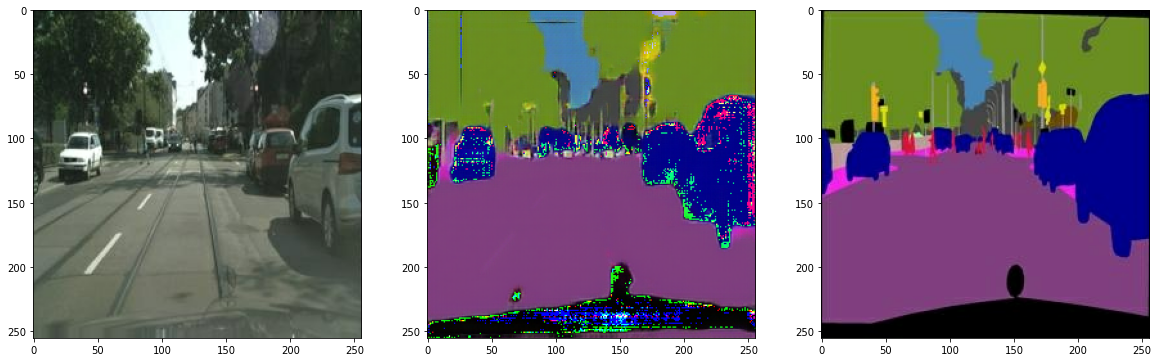

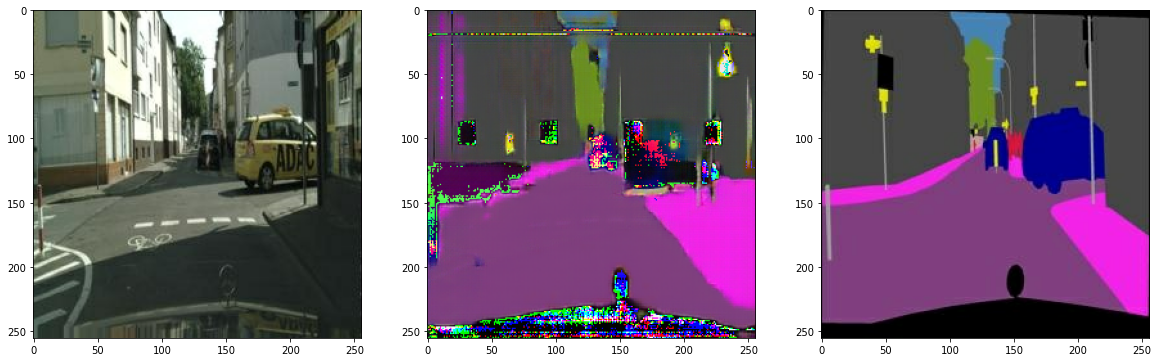

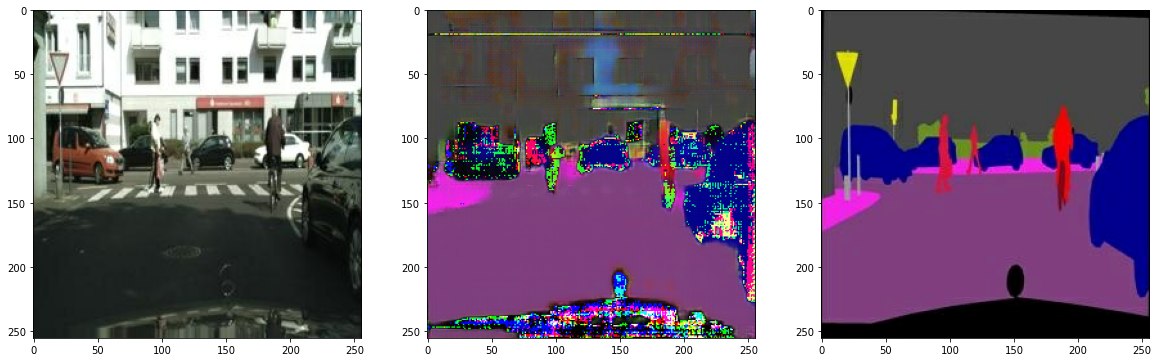

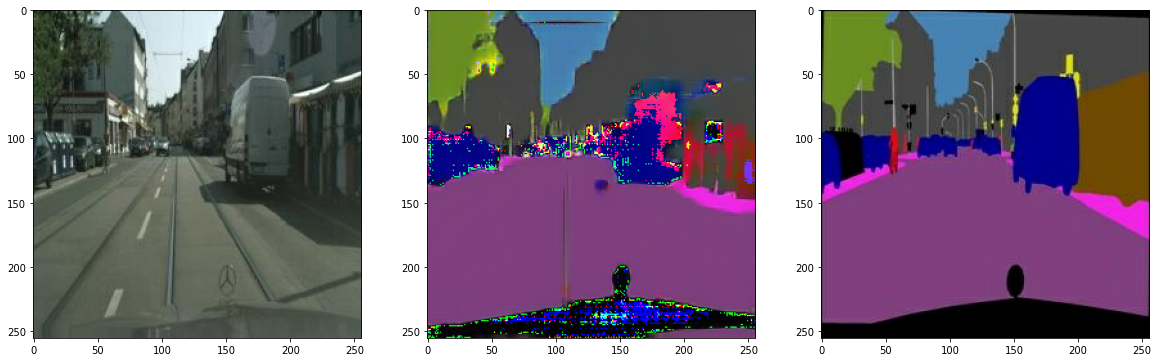

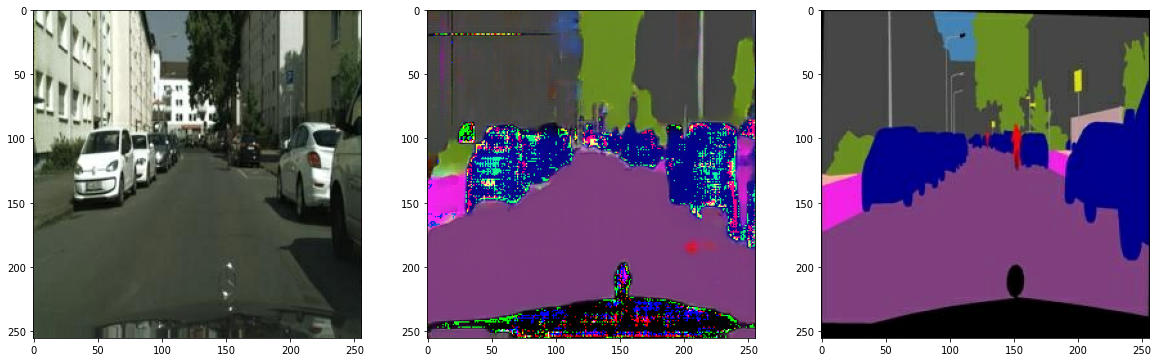

In [28]:
test_ind = 1

for i in range(len(os.listdir(val_data_path))):
    f = val_data_path + os.listdir(val_data_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

### 회고
---
Gan의 생성 과정에서 노이즈로 인한 불안정함을 해소하는 모델을 배웠다는 점에서 의미있는 노드로 다가옵니다.\
수식에 대해서는 아직 이해가 부족한데, 이는 시간을 들여서 이해도를 높여야 할 것 같습니다.\
